In [1]:
import sys

sys.path.insert(0, "../utils")

In [2]:
import importlib  
import math
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.auto import tqdm, trange
from weighted_fm import WeightedFFM, WeightedFM
import numpy as np
from functools import partial
import pandas as pd
from bisect import bisect_left
import subprocess
from old_spline_utils import get_spline_basis

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [4]:
sns.set()
sns.set_context("poster")

In [5]:
def pctrFuncTemplate(a, b, bump, x):
    power = 1.5
    return a / np.power(b + a + x, power) + (a / np.power(b + a, power)) / np.cosh((x - bump) / 5)

In [6]:
categoricalTable = [
    [ "Young", "Male", "Ad 1"],
    [ "Young", "Female", "Ad 1"],
    [ "Old", "Male", "Ad 1"],
    [ "Old", "Female", "Ad 1" ],
    [ "Young", "Male", "Ad 2"],
    [ "Young", "Female", "Ad 2"],
    [ "Old", "Male", "Ad 2"],
    [ "Old", "Female", "Ad 2" ]]

In [7]:
recencyPctrFunctions = [
    partial(pctrFuncTemplate, 20, 5, 10),
    partial(pctrFuncTemplate, 20, 10, 11),
    partial(pctrFuncTemplate, 10, 5, 12),
    partial(pctrFuncTemplate, 10, 10, 13),
    partial(pctrFuncTemplate, 20, 5, 31),
    partial(pctrFuncTemplate, 20, 10, 32),
    partial(pctrFuncTemplate, 10, 5, 33),
    partial(pctrFuncTemplate, 10, 10, 34),
]

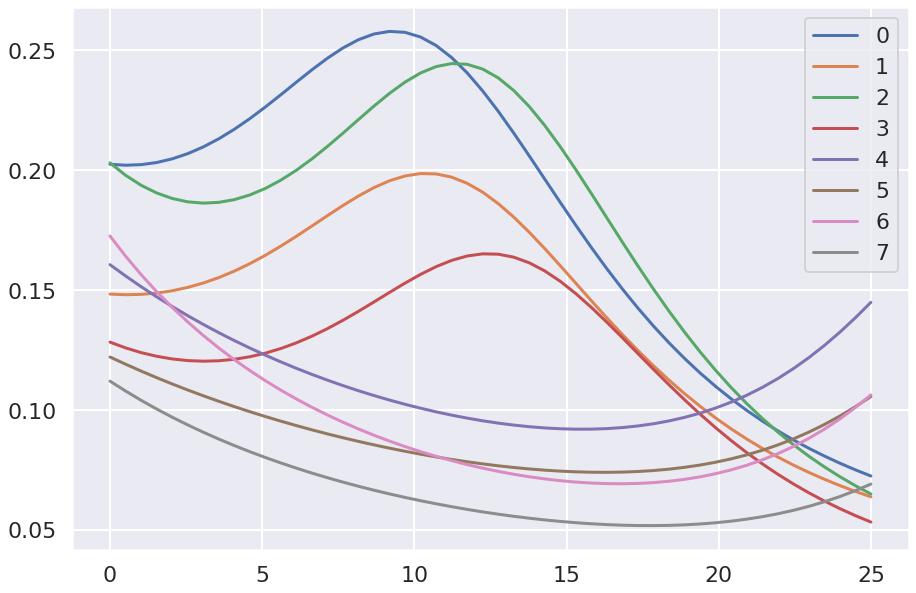

In [8]:
xs = np.linspace(0, 25)
plt.figure(figsize=(15, 10))
for i, f in enumerate(recencyPctrFunctions):
    ys = f(xs)
    plt.plot(xs, ys, label=str(i))
plt.legend()
plt.show()

In [83]:
def generate_random_dataset(dataset_size, categoricalTable, max_recency=40, seed=85765373):
    rng = np.random.default_rng(seed)
    configs = rng.choice(len(categoricalTable), dataset_size)
    ages = [categoricalTable[cfg][0] for cfg in configs]
    genders = [categoricalTable[cfg][1] for cfg in configs]
    ads = [categoricalTable[cfg][2] for cfg in configs]
    recencies = rng.binomial(max_recency * 99, rng.beta(0.9, 1.2, dataset_size)) / 100
    
    return configs, ages, genders, ads, recencies

In [10]:
def compute_ctrs(configs, recencies, recencyPctrFunctions):
    return [recencyPctrFunctions[cfg](recency) for cfg, recency in zip(configs, recencies)]

In [11]:
def make_random_labels(configs, recencies, recencyPctrFunctions, seed=36473755):
    generator = torch.Generator()
    generator.manual_seed(seed)

    pctrs = np.asarray(compute_ctrs(configs, recencies, recencyPctrFunctions))
    pctrs = torch.as_tensor(pctrs)
    
    labels = torch.bernoulli(pctrs, generator=generator)
    optimal_loss = torch.log1p(-pctrs[labels == 0]).sum() + np.log(pctrs[labels == 1]).sum()
    
    return labels, -optimal_loss.item() / len(labels)

In [12]:
def make_feature_map(categoricalTable, basis_names):
    categories = list(set(sum(categoricalTable, [])))
    def reverse_pair(pair):
        return pair[1], pair[0]
    return dict(map(reverse_pair, enumerate(categories + basis_names)))

In [13]:
def recency_pair(recency, basis, searcher, basis_names, feature_map, max_recency=40):
    normalized = recency / max_recency
    feature_idx = [feature_map[basis_names[i]] for i in searcher(normalized)]
    weights = [basis[i](normalized).item() for i in searcher(normalized)]
    
    return torch.tensor(feature_idx), torch.tensor(weights)

In [14]:
def generate_plotting_dataset(categoricalTable, max_recency=40, num_samples=1000):
    cfgs = np.repeat(np.arange(len(categoricalTable)), num_samples)
    ages = [categoricalTable[cfg][0] for cfg in cfgs]
    genders = [categoricalTable[cfg][1] for cfg in cfgs]
    ads = [categoricalTable[cfg][2] for cfg in cfgs]
    recencies = np.tile(np.linspace(0, max_recency, num_samples, endpoint=False), len(categoricalTable))
    return cfgs, ages, genders, ads, recencies

In [119]:
from sklearn.preprocessing import QuantileTransformer

def make_tensors(ages, genders, ads, recencies, basis, basis_searcher, basis_names, feature_map, quantiles=False):
    num_columns = 3 + basis_searcher.order
    num_fields = 4
    weight_coef = 1. / math.sqrt(num_fields)

    age_idx = torch.tensor([feature_map[age] for age in ages]).unsqueeze(1)
    age_weights = torch.ones_like(age_idx)

    gender_idx = torch.tensor([feature_map[gender] for gender in genders]).unsqueeze(1)
    gender_weights = torch.ones_like(gender_idx)

    ad_idx = torch.tensor([feature_map[ad] for ad in ads]).unsqueeze(1)
    ad_weights = torch.ones_like(ad_idx)
    
    if quantiles:
        tr = QuantileTransformer(n_quantiles=10000, subsample=50000)
        recencies = tr.fit_transform(recencies.reshape(-1, 1)).reshape(-1)
        max_recency = 1
    else:
        max_recency = 40

    recency_pairs = [recency_pair(recency, basis, basis_searcher, basis_names, feature_map, max_recency=max_recency) for recency in recencies]
    recency_idx = torch.vstack([pair[0] for pair in recency_pairs])
    recency_weights = torch.vstack([pair[1] for pair in recency_pairs])

    indices = torch.hstack([age_idx, gender_idx, ad_idx, recency_idx])
    weights = weight_coef * torch.hstack([age_weights, gender_weights, ad_weights, recency_weights])
    offsets = torch.tensor([0, 1, 2, num_columns - 1]).expand(indices.shape[0], 4)
    fields = torch.tensor([0, 1, 2, 3]).expand(indices.shape[0], 4)
    return indices, weights, offsets, fields


def make_tensor_dataset(ages, genders, ads, recencies, labels, basis, basis_searcher, basis_names, feature_map):
    indices, weights, offsets, fields = make_tensors(ages, genders, ads, recencies, basis, basis_searcher, basis_names, feature_map)
    labels = torch.as_tensor(labels).to(dtype=torch.float32).unsqueeze(1)
    return torch.utils.data.TensorDataset(indices.to(device), weights.to(device), offsets.to(device), fields.to(device), labels.to(device))

In [16]:
def fit_model(dataset, num_features, epochs=6, lr=0.08, weight_decay=1e-4, batch_size=128, train_frac=0.25):
    trainset_size = int(train_frac * len(dataset))
    trainset, testset = torch.utils.data.random_split(dataset, [trainset_size, len(dataset) - trainset_size])
    print(trainset_size, len(testset))
    
    model = WeightedFFM(num_features=num_features, field_dim=4, num_fields=4).to(device)
    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss()
    for epoch in trange(1, 1 + epochs):
        train_loss = 0.
        for indices, weights, offsets, fields, labels in tqdm(torch.utils.data.DataLoader(trainset, batch_size=batch_size), desc='train', leave=False):
            pred = model(indices, weights, offsets, fields)
            optimizer.zero_grad()
            loss = criterion(pred, labels.squeeze())
            loss.backward()
            optimizer.step()    
            train_loss += loss.item() * labels.numel()
        train_loss /= trainset_size
        
        with torch.no_grad():
            for indices, weights, offsets, fields, labels in tqdm(torch.utils.data.DataLoader(testset, batch_size=len(testset)), desc='test', leave=False):
                pred = model(indices, weights, offsets, fields)
                loss = criterion(pred, labels.squeeze())
                test_loss = loss.item()
        
        print(f'Epoch = {epoch}, train loss = {train_loss}, test_loss = {test_loss}')
        
    return model.to('cpu'), test_loss

In [114]:
def generate_plotting_dataframe(model, categoricalTable, recencyPctrFunctions, basis, basis_searcher, basis_names, feature_map):
    cfgs, ages, genders, ads, recencies = generate_plotting_dataset(categoricalTable)
    ctrs = compute_ctrs(cfgs, recencies, recencyPctrFunctions)
    indices, weights, offsets, fields = make_tensors(ages, genders, ads, recencies, basis, basis_searcher, basis_names, feature_map, quantiles=False)
    with torch.no_grad():
        pctrs = torch.sigmoid(model(indices, weights, offsets, fields)).numpy()
    df = pd.DataFrame({'config': cfgs, 'recency': recencies, 'ctr': ctrs, 'pctr': pctrs})
    return df.melt(id_vars=['config', 'recency'])

In [127]:
def plot_torch_ffm_curves(categoricalTable, recencyPctrFunctions, order=4, num_knots=10, dataset_size=100000, fit_params=dict()):
    configs, ages, genders, ads, recencies = generate_random_dataset(dataset_size, categoricalTable)
    labels, optimal_loss = make_random_labels(configs, recencies, recencyPctrFunctions)
    print(f'Optimal loss = {optimal_loss}')

    basis, basis_searcher = get_spline_basis(num_knots, order)
    basis_names = [f'B_{i}' for i in range(len(basis))]
    feature_map = make_feature_map(categoricalTable, basis_names)
    
    dataset = make_tensor_dataset(ages, genders, ads, recencies, labels, basis, basis_searcher, basis_names, feature_map)
    model, test_loss = fit_model(dataset, len(feature_map), **fit_params)
    df = generate_plotting_dataframe(model, categoricalTable, recencyPctrFunctions, basis, basis_searcher, basis_names, feature_map)
    df = df.rename({'config': 'Segment', 'variable': 'Function', 'recency': 'Num. field'}, axis=1)
    g = sns.FacetGrid(df, col='Segment', hue='Function', col_wrap=4, height=5)
    g.map_dataframe(sns.lineplot, x='Num. field', y='value')
    g.add_legend()
    return g

In [19]:
def plot_two_learned_curves(categoricalTable, recencyPctrFunctions, num_knots_a, num_knots_b,
                            dataset_size=100000, fit_params=dict()):
    configs, ages, genders, ads, recencies = generate_random_dataset(dataset_size, categoricalTable)
    labels, optimal_loss = make_random_labels(configs, recencies, recencyPctrFunctions)
    print(f'Optimal loss = {optimal_loss}')

    tqdm.write('Experiment A\n')
    basis, basis_searcher = get_spline_basis(num_knots_a, order=1)
    basis_names = [f'B_{i}' for i in range(len(basis))]
    feature_map = make_feature_map(categoricalTable, basis_names)
    dataset = make_tensor_dataset(ages, genders, ads, recencies, labels, basis, basis_searcher, basis_names, feature_map)
    model, test_loss_a = fit_model(dataset, len(feature_map), **fit_params)
    plot_df_a = generate_plotting_dataframe(model, categoricalTable, recencyPctrFunctions, basis, basis_searcher, basis_names, feature_map)

    tqdm.write('Experiment B\n')
    basis, basis_searcher = get_spline_basis(num_knots_b, order=4)
    basis_names = [f'B_{i}' for i in range(len(basis))]
    feature_map = make_feature_map(categoricalTable, basis_names)
    dataset = make_tensor_dataset(ages, genders, ads, recencies, labels, basis, basis_searcher, basis_names, feature_map)
    model, test_loss_b = fit_model(dataset, len(feature_map), **fit_params)
    plot_df_b = generate_plotting_dataframe(model, categoricalTable, recencyPctrFunctions, basis, basis_searcher, basis_names, feature_map)

    plot_df_a.drop(plot_df_a[plot_df_a['variable'] == 'ctr'].index, inplace=True)
    plot_df_a['variable'] = plot_df_a['variable'].replace('pctr', f'{num_knots_a}-bins pCTR')

    plot_df_b['variable'] = plot_df_b['variable'].replace('ctr', f'Simulation CTR')
    plot_df_b['variable'] = plot_df_b['variable'].replace('pctr', f'{num_knots_b}-knot spline pCTR')
    
    df = pd.concat([plot_df_a, plot_df_b], axis=0)
    df = df.rename({'variable': 'Function'}, axis=1)
    
    g = sns.FacetGrid(df, col='config', hue='Function', col_wrap=3, height=7)
    g.map_dataframe(sns.lineplot, x='recency', y='value')
    g.add_legend()
    plt.show()    

Optimal loss = 0.34762783212189957
Experiment A

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3592145357036591, test_loss = 0.3511349558830261


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3488208832836151, test_loss = 0.34967800974845886


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3478114691925049, test_loss = 0.34937962889671326


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3474595821285248, test_loss = 0.34927278757095337


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34727097716331484, test_loss = 0.349222868680954


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34714720973968505, test_loss = 0.34919676184654236
Experiment B

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3607344654941559, test_loss = 0.35143280029296875


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34822594482421876, test_loss = 0.34969308972358704


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3472896607112885, test_loss = 0.3493436574935913


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34701497074127197, test_loss = 0.3492189347743988


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3468857153892517, test_loss = 0.3491535484790802


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3468081254577637, test_loss = 0.349111407995224


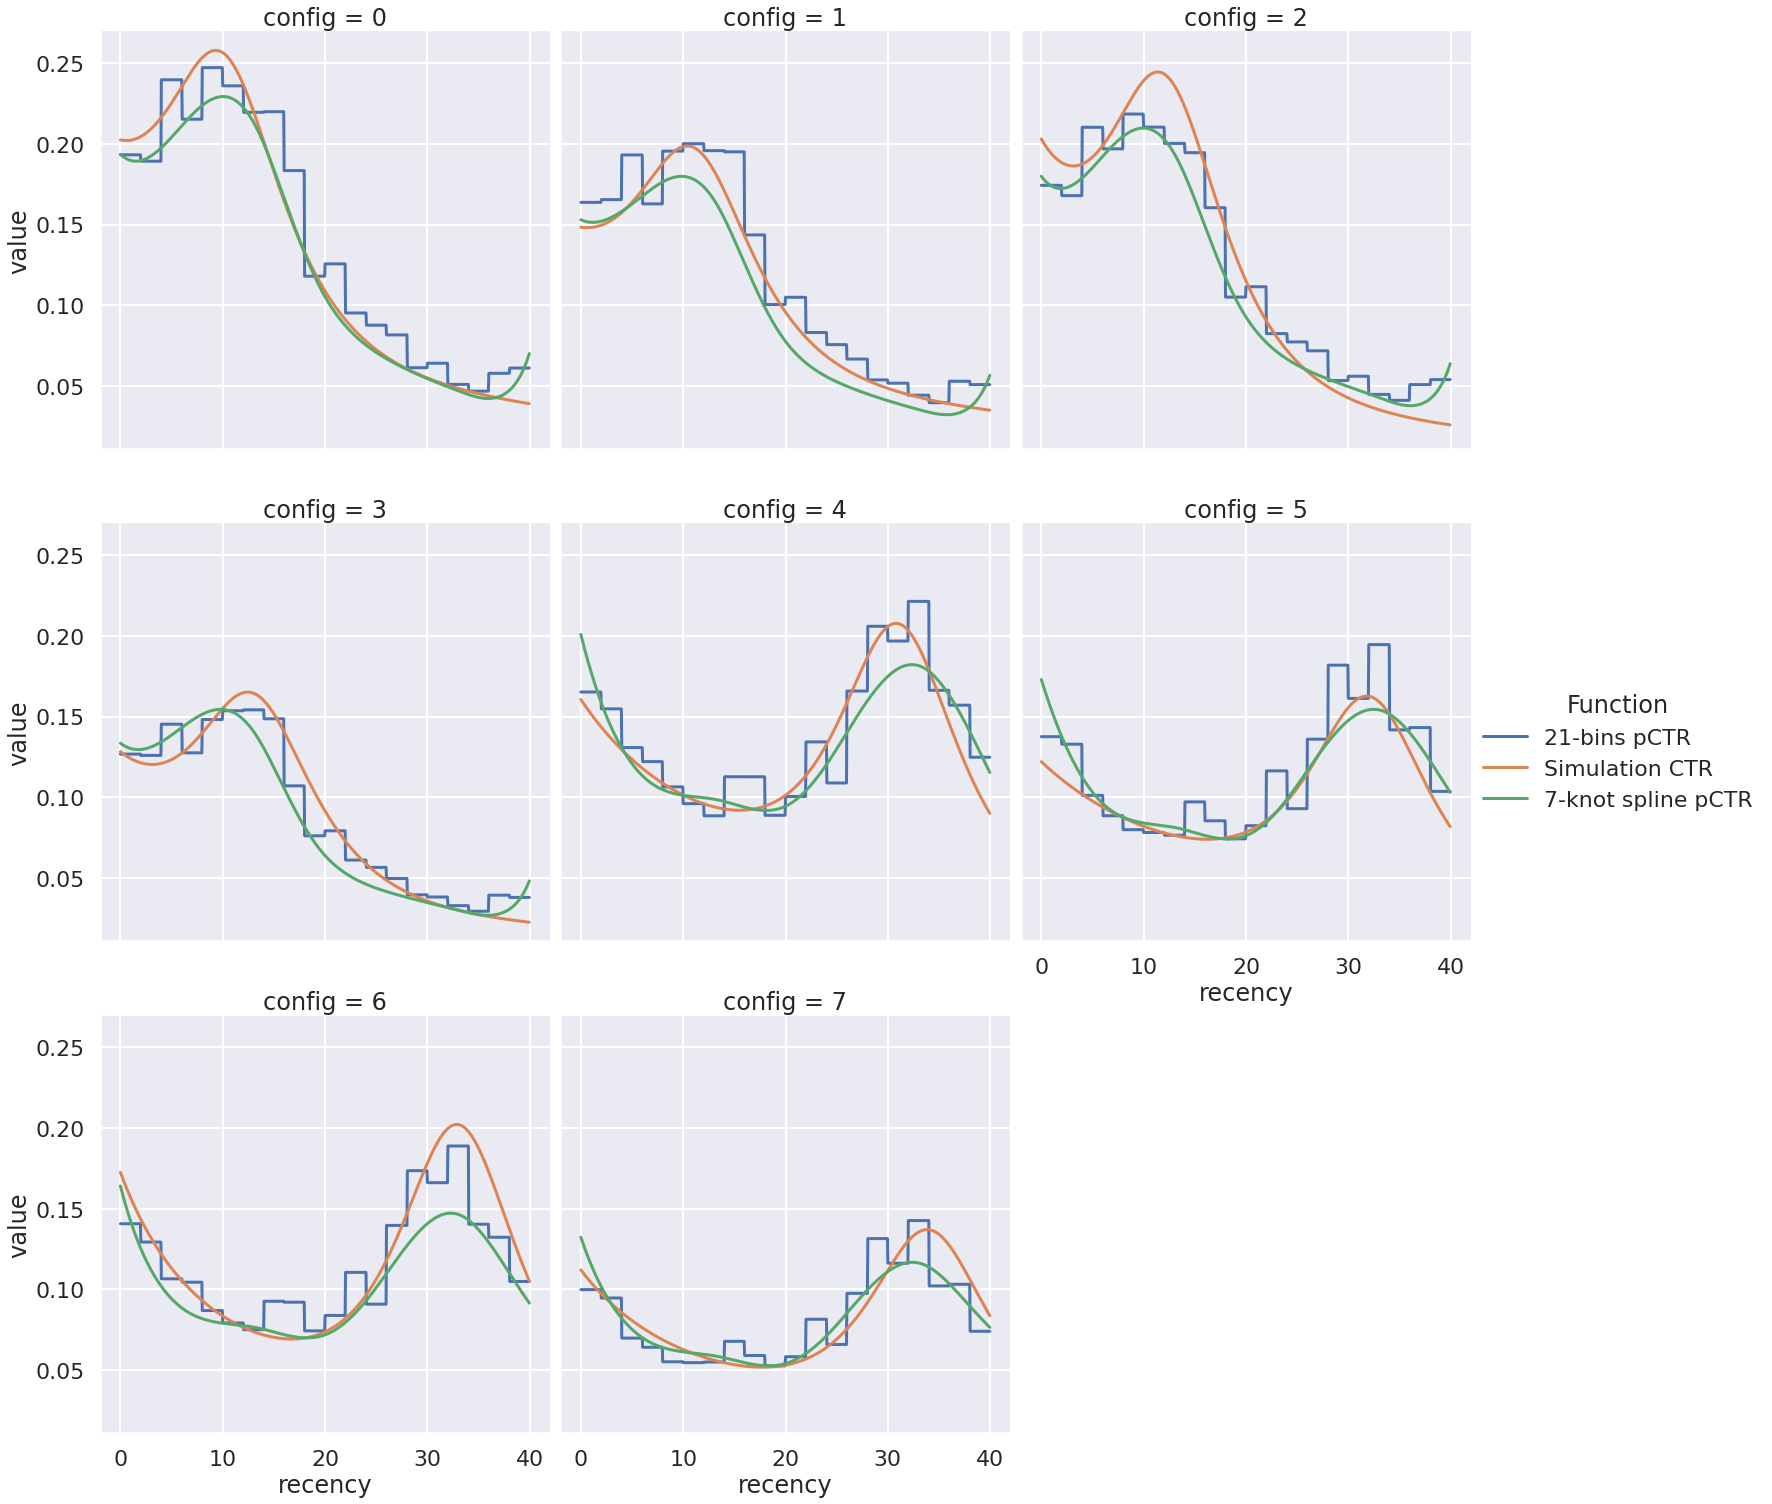

In [20]:
plot_two_learned_curves(categoricalTable, recencyPctrFunctions, num_knots_a=21, num_knots_b=7)

In [21]:
def plot_binning_vs_spline_accuracy(categoricalTable, recencyPctrFunctions, knot_counts,
                                    dataset_size=100000, fit_params=dict()):
    configs, ages, genders, ads, recencies = generate_random_dataset(dataset_size, categoricalTable)
    labels, optimal_loss = make_random_labels(configs, recencies, recencyPctrFunctions)
    print(f'Optimal loss = {optimal_loss}')

    results = []
    for attempt in range(15):
        for num_knots in knot_counts:
            tqdm.write(f'Bins with num_knots = {num_knots}\n')
            basis, basis_searcher = get_spline_basis(num_knots, order=1)
            basis_names = [f'B_{i}' for i in range(len(basis))]
            feature_map = make_feature_map(categoricalTable, basis_names)
            dataset = make_tensor_dataset(ages, genders, ads, recencies, labels, basis, basis_searcher, basis_names, feature_map)
            model, test_loss_a = fit_model(dataset, len(feature_map), **fit_params)

            tqdm.write(f'Splines with num_knots = {num_knots}\n')
            basis, basis_searcher = get_spline_basis(num_knots, order=4)
            basis_names = [f'B_{i}' for i in range(len(basis))]
            feature_map = make_feature_map(categoricalTable, basis_names)
            dataset = make_tensor_dataset(ages, genders, ads, recencies, labels, basis, basis_searcher, basis_names, feature_map)
            model, test_loss_b = fit_model(dataset, len(feature_map), **fit_params)

            results.append((num_knots, test_loss_a, test_loss_b))
    
    
    return pd.DataFrame(results, columns=['# boundaries', 'bins', 'splines'])

In [22]:
df = plot_binning_vs_spline_accuracy(categoricalTable, recencyPctrFunctions, np.round(np.geomspace(5, 80, 15)).astype(np.int32))

Optimal loss = 0.34762783212189957
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3559346954488754, test_loss = 0.35270121693611145


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3482794140720367, test_loss = 0.35203978419303894


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3480055149412155, test_loss = 0.3518226444721222


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3478927321958542, test_loss = 0.35170960426330566


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3478265609073639, test_loss = 0.3516390025615692


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.347781714015007, test_loss = 0.3515903651714325
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3530119523525238, test_loss = 0.3520077168941498


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3423273925304413, test_loss = 0.3509978950023651


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34174198554039004, test_loss = 0.3508039116859436


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34154584765434265, test_loss = 0.3507431149482727


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34144532175064085, test_loss = 0.3507196307182312


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.341382166595459, test_loss = 0.35070979595184326
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36554173601150514, test_loss = 0.3487323224544525


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3559617796230316, test_loss = 0.3477663993835449


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35553493180274964, test_loss = 0.3476226329803467


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35540057357788085, test_loss = 0.3475891649723053


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3553274308013916, test_loss = 0.3475813567638397


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3552786217021942, test_loss = 0.3475814461708069
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35996589270591733, test_loss = 0.348996102809906


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3500287148189545, test_loss = 0.3482872247695923


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3495770904350281, test_loss = 0.3481450378894806


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3494158134841919, test_loss = 0.3480834662914276


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3493248448753357, test_loss = 0.3480483591556549


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3492635807800293, test_loss = 0.3480255603790283
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35623975609779357, test_loss = 0.3514275550842285


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34661412766456606, test_loss = 0.3505444824695587


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3461553774738312, test_loss = 0.3503738045692444


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34600024788856504, test_loss = 0.3503074645996094


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3459146392917633, test_loss = 0.35027357935905457


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3458577489376068, test_loss = 0.35025379061698914
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36702277818679807, test_loss = 0.3497154116630554


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3557842030239105, test_loss = 0.3472062945365906


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35449816423416136, test_loss = 0.34680813550949097


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3542033044528961, test_loss = 0.34665238857269287


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35407050628662107, test_loss = 0.34656381607055664


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3539910950565338, test_loss = 0.3465059995651245
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36404327795028685, test_loss = 0.3532688021659851


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35291474502563475, test_loss = 0.34997910261154175


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3510295138168335, test_loss = 0.34922489523887634


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35049523139953614, test_loss = 0.34901750087738037


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3502737921524048, test_loss = 0.3489414155483246


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35015276224136355, test_loss = 0.34890803694725037
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3655546916294098, test_loss = 0.34796157479286194


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3552161886024475, test_loss = 0.3467381000518799


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3546245983123779, test_loss = 0.34655094146728516


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35444800616264344, test_loss = 0.3464885950088501


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3543548347568512, test_loss = 0.3464585840702057


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3542937898159027, test_loss = 0.34644100069999695
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3546052372741699, test_loss = 0.3539525270462036


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3444795306777954, test_loss = 0.35186779499053955


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34318183028221133, test_loss = 0.3513379991054535


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34271197335243225, test_loss = 0.35117998719215393


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34247728014945983, test_loss = 0.3511335849761963


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.342333255777359, test_loss = 0.3511272966861725
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35431475687026975, test_loss = 0.3505370318889618


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34466006876945493, test_loss = 0.35004380345344543


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3442706795787811, test_loss = 0.3499586582183838


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3441070067024231, test_loss = 0.34993699193000793


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3440114071559906, test_loss = 0.3499310612678528


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34394645212173464, test_loss = 0.3499297797679901
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35874006658554075, test_loss = 0.35043978691101074


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34804127851486205, test_loss = 0.34962016344070435


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34736383913993835, test_loss = 0.3494243621826172


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34712517207145693, test_loss = 0.3493310511112213


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34699544076919553, test_loss = 0.34927329421043396


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3469092200565338, test_loss = 0.3492336869239807
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36326606104850767, test_loss = 0.34886083006858826


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35331309109687803, test_loss = 0.34754499793052673


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35247202301025393, test_loss = 0.34727978706359863


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.352201871843338, test_loss = 0.3471921980381012


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3520682745456696, test_loss = 0.3471525013446808


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35198511169433594, test_loss = 0.34713056683540344
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3561419303798676, test_loss = 0.3544048070907593


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3454587796020508, test_loss = 0.3518681824207306


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3440507174873352, test_loss = 0.3512345552444458


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34360073533058166, test_loss = 0.3510228395462036


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3433807499694824, test_loss = 0.35093459486961365


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3432421320438385, test_loss = 0.3508947789669037
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3648834369945526, test_loss = 0.3502851128578186


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35466481764793395, test_loss = 0.34805580973625183


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3531698361873627, test_loss = 0.3475162982940674


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35267368111610414, test_loss = 0.34732726216316223


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35243626467704775, test_loss = 0.34723931550979614


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3522951828670502, test_loss = 0.3471905589103699
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36166575330257417, test_loss = 0.35108453035354614


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3518140012073517, test_loss = 0.3486914038658142


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3503707801914215, test_loss = 0.34825634956359863


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34996300812721254, test_loss = 0.34812936186790466


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.349773017244339, test_loss = 0.34807172417640686


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34965498219013214, test_loss = 0.34803786873817444
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3574953300666809, test_loss = 0.3536226451396942


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3462053267002106, test_loss = 0.3507266342639923


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34448641528129575, test_loss = 0.35014769434928894


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34402638246536255, test_loss = 0.3500005602836609


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3438292604923248, test_loss = 0.349945992231369


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34371114505767825, test_loss = 0.34992051124572754
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36585948627471926, test_loss = 0.35121941566467285


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35481936016082766, test_loss = 0.3487500250339508


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3534011667013168, test_loss = 0.3480808436870575


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35289500989437106, test_loss = 0.34784960746765137


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3526272408056259, test_loss = 0.34775862097740173


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35245107902526857, test_loss = 0.34772515296936035
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36215552538871765, test_loss = 0.34959280490875244


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3524016775035858, test_loss = 0.34835147857666016


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3515014539527893, test_loss = 0.34809550642967224


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3511714521598816, test_loss = 0.3480120301246643


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35099212622642517, test_loss = 0.34797659516334534


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35087348315238953, test_loss = 0.3479588031768799
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36119398693084714, test_loss = 0.3552190661430359


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34866144088745116, test_loss = 0.3523204028606415


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34677889022827146, test_loss = 0.35136547684669495


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3460757688522339, test_loss = 0.35095587372779846


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34573258016586306, test_loss = 0.3507326543331146


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34552584100723266, test_loss = 0.35059213638305664
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35439129744529724, test_loss = 0.35300323367118835


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3441984534740448, test_loss = 0.35152560472488403


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3432826459026337, test_loss = 0.35117146372795105


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3429212857055664, test_loss = 0.3510395288467407


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3427114867401123, test_loss = 0.3509809970855713


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3425667440891266, test_loss = 0.35095375776290894
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36111153239727023, test_loss = 0.35334864258766174


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.350087865562439, test_loss = 0.35116249322891235


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3486141330718994, test_loss = 0.35042905807495117


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3480239968824387, test_loss = 0.3501112461090088


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34770839675426485, test_loss = 0.34994298219680786


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3475030444288254, test_loss = 0.3498426079750061
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3661051613044739, test_loss = 0.3504176437854767


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3544199149608612, test_loss = 0.34826141595840454


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35289036608695984, test_loss = 0.3476771414279938


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3523468733882904, test_loss = 0.34746432304382324


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3520764727592468, test_loss = 0.3473643660545349


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3519087863445282, test_loss = 0.3473089337348938
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3693706827640533, test_loss = 0.35433050990104675


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.357520946969986, test_loss = 0.3516182005405426


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3549920891666412, test_loss = 0.3501091003417969


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35356038986206056, test_loss = 0.3493264317512512


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3527196847057342, test_loss = 0.34891578555107117


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35218628134727475, test_loss = 0.34869420528411865
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35896563227653505, test_loss = 0.3512189984321594


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3463280823230743, test_loss = 0.35016801953315735


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3452278042125702, test_loss = 0.3499583303928375


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3447878532886505, test_loss = 0.34989187121391296


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3445301973724365, test_loss = 0.34986892342567444


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34434923392295835, test_loss = 0.3498641550540924
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3670253391933441, test_loss = 0.3511211574077606


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35453329200744627, test_loss = 0.34916141629219055


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3528578276252747, test_loss = 0.3485758304595947


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35216074095726013, test_loss = 0.3483288884162903


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3517683997249603, test_loss = 0.3481985032558441


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3515012379360199, test_loss = 0.34812068939208984
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3591233020973206, test_loss = 0.35282886028289795


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3472588754272461, test_loss = 0.35099032521247864


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34573713032722475, test_loss = 0.3505609333515167


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.345142452878952, test_loss = 0.35041892528533936


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34481355490684507, test_loss = 0.35035890340805054


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3445911273002625, test_loss = 0.35033005475997925
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35834498973846435, test_loss = 0.35669758915901184


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3448906339836121, test_loss = 0.3541298806667328


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34216848991394044, test_loss = 0.353257954120636


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3409527425956726, test_loss = 0.352940171957016


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34027218454360963, test_loss = 0.352817565202713


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3398122706794739, test_loss = 0.35278087854385376
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36413540820121765, test_loss = 0.35137003660202026


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3522029926586151, test_loss = 0.3496342599391937


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35080937232971193, test_loss = 0.3491193354129791


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35021707330703733, test_loss = 0.3489105701446533


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3498808309841156, test_loss = 0.34880703687667847


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34965512979507446, test_loss = 0.3487494885921478
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3659673995113373, test_loss = 0.3531776964664459


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3535917669582367, test_loss = 0.35058608651161194


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3510585379219055, test_loss = 0.34982284903526306


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34992683619499204, test_loss = 0.3495764434337616


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3492712940311432, test_loss = 0.34950029850006104


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34881690047264097, test_loss = 0.34949374198913574
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36262876205444333, test_loss = 0.35342493653297424


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3496316246986389, test_loss = 0.35110732913017273


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3476592405605316, test_loss = 0.35044610500335693


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34683035332679746, test_loss = 0.3502086400985718


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3463637365722656, test_loss = 0.35010603070259094


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3460443839263916, test_loss = 0.3500588536262512
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3578737015724182, test_loss = 0.3530784845352173


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34744301368713376, test_loss = 0.3522723913192749


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34710390360832216, test_loss = 0.35210371017456055


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34698783555984497, test_loss = 0.3520331382751465


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3469194023323059, test_loss = 0.3519946038722992


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3468716090583801, test_loss = 0.3519707918167114
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3566471041584015, test_loss = 0.3519514799118042


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.348189654083252, test_loss = 0.35000932216644287


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3475416330623627, test_loss = 0.3494953513145447


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34733262216567995, test_loss = 0.3492845892906189


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3472254201793671, test_loss = 0.3491758704185486


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3471569591712952, test_loss = 0.34911197423934937
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3598828176498413, test_loss = 0.34994977712631226


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35174569924354554, test_loss = 0.34944525361061096


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35132495991706847, test_loss = 0.34933844208717346


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.351175956659317, test_loss = 0.34928733110427856


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35109264480113983, test_loss = 0.34925577044487


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35103671561717986, test_loss = 0.349234014749527
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3562505362987518, test_loss = 0.35565343499183655


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3465124077129364, test_loss = 0.3517376184463501


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34409501479148863, test_loss = 0.3505813479423523


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34341439982414246, test_loss = 0.35029149055480957


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34317748805046083, test_loss = 0.35019630193710327


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3430600027370453, test_loss = 0.3501567840576172
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36167831778526305, test_loss = 0.34991902112960815


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35320227294921874, test_loss = 0.3489318788051605


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3527092514038086, test_loss = 0.3487009108066559


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3525096889305115, test_loss = 0.3486239016056061


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35239816137313845, test_loss = 0.348593533039093


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3523259367752075, test_loss = 0.34858009219169617
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35906099840164185, test_loss = 0.3496350646018982


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34786162225723266, test_loss = 0.3488542139530182


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34736494388580325, test_loss = 0.34870949387550354


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34717833649635316, test_loss = 0.3486548364162445


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34706922695159914, test_loss = 0.34863051772117615


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3469953807926178, test_loss = 0.34861934185028076
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36113145651817324, test_loss = 0.35322678089141846


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3501134706401825, test_loss = 0.35029077529907227


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34855929878234865, test_loss = 0.34970343112945557


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34812674310684205, test_loss = 0.3495527505874634


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3479289544200897, test_loss = 0.3495086431503296


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34780905463218686, test_loss = 0.349499374628067
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36015534370422364, test_loss = 0.3507659435272217


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.349400350151062, test_loss = 0.3489757776260376


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3484758268070221, test_loss = 0.3487263023853302


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3482515822887421, test_loss = 0.3486456573009491


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3481437279987335, test_loss = 0.3486036956310272


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3480747439956665, test_loss = 0.34857669472694397
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3612548384952545, test_loss = 0.3502137362957001


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3510981652116775, test_loss = 0.3487997353076935


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3503740573978424, test_loss = 0.34856051206588745


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35014256791114806, test_loss = 0.34849318861961365


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3500185524749756, test_loss = 0.3484697639942169


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34993637231349944, test_loss = 0.34846174716949463
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3598907979774475, test_loss = 0.3503756821155548


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3494989125919342, test_loss = 0.34911787509918213


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34862061960220336, test_loss = 0.3488427996635437


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34834669043540956, test_loss = 0.3487263321876526


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3482081448554993, test_loss = 0.3486659824848175


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34812248330116274, test_loss = 0.34863099455833435
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3564880738067627, test_loss = 0.35279548168182373


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34474862513542176, test_loss = 0.351242333650589


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3439262647247314, test_loss = 0.35086485743522644


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.343634505777359, test_loss = 0.3507217764854431


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34347593553543093, test_loss = 0.3506549596786499


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3433704400539398, test_loss = 0.3506211042404175
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35657236448287966, test_loss = 0.3512117266654968


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34570084268569945, test_loss = 0.3501793146133423


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.345076421661377, test_loss = 0.34997183084487915


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34486296026229857, test_loss = 0.34989795088768005


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3447493095207214, test_loss = 0.3498620390892029


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34467509740829466, test_loss = 0.34984105825424194
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36388696078300475, test_loss = 0.34984099864959717


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3545035499572754, test_loss = 0.34862175583839417


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35381317423820496, test_loss = 0.3482871651649475


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35355992418289184, test_loss = 0.3481265902519226


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35342136805534363, test_loss = 0.3480267822742462


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35332938099861144, test_loss = 0.3479560613632202
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35806607016563413, test_loss = 0.35031774640083313


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3470910175991058, test_loss = 0.3493746221065521


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3463724232387543, test_loss = 0.3492303192615509


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34611559817314147, test_loss = 0.3491882085800171


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34596775147438047, test_loss = 0.34917426109313965


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3458647137355804, test_loss = 0.34917140007019043
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3624526956558228, test_loss = 0.35211607813835144


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3517386187171936, test_loss = 0.34956687688827515


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35012608598709105, test_loss = 0.3488718271255493


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34958050090789794, test_loss = 0.3486305773258209


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3493262568473816, test_loss = 0.3485236167907715


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3491752145767212, test_loss = 0.34846818447113037
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35867153537750246, test_loss = 0.350472092628479


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3487179968547821, test_loss = 0.34960609674453735


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34813088519096375, test_loss = 0.3494246304035187


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3479035840797424, test_loss = 0.34935081005096436


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3477687879371643, test_loss = 0.3493117094039917


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3476748808956146, test_loss = 0.34928834438323975
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.361017003030777, test_loss = 0.3560523986816406


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34788048082351686, test_loss = 0.3524673283100128


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3453950933933258, test_loss = 0.351343035697937


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3445622576141357, test_loss = 0.35094594955444336


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34419372955322264, test_loss = 0.35076457262039185


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3439807081604004, test_loss = 0.3506678342819214
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3590566770362854, test_loss = 0.35045281052589417


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3480982871246338, test_loss = 0.3494526445865631


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34725959425926206, test_loss = 0.34923577308654785


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34693137102127075, test_loss = 0.3491625189781189


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34674851925849914, test_loss = 0.34913262724876404


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3466277999305725, test_loss = 0.34911996126174927
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3609581342506409, test_loss = 0.35354459285736084


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3494580366802216, test_loss = 0.3508621156215668


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3476141414642334, test_loss = 0.350066602230072


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34693177565574645, test_loss = 0.3497811555862427


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34659112394332886, test_loss = 0.3496573865413666


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3463800845623016, test_loss = 0.3495977222919464
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36153650512218477, test_loss = 0.35033783316612244


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3509928983259201, test_loss = 0.34915587306022644


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3500661788892746, test_loss = 0.3488403260707855


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34969131989479063, test_loss = 0.34871429204940796


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3494794540500641, test_loss = 0.3486519157886505


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3493370514011383, test_loss = 0.3486171066761017
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3622361537504196, test_loss = 0.35374099016189575


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35065968720436097, test_loss = 0.3511243164539337


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3482031052350998, test_loss = 0.35017192363739014


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34716488093853, test_loss = 0.34984129667282104


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34665191821575164, test_loss = 0.3497115969657898


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34634154891490937, test_loss = 0.3496564030647278
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35999498131752017, test_loss = 0.3522466719150543


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34923527190208437, test_loss = 0.35021087527275085


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3478329814815521, test_loss = 0.34970006346702576


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34734750208854676, test_loss = 0.3495165705680847


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3471069527626038, test_loss = 0.34942924976348877


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34695851000785827, test_loss = 0.3493798077106476
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.360577707195282, test_loss = 0.35389479994773865


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34892674954414366, test_loss = 0.3513837158679962


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3470985949039459, test_loss = 0.35067546367645264


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34635349650382996, test_loss = 0.35043439269065857


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3459489067363739, test_loss = 0.3503440022468567


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3456877436923981, test_loss = 0.3503124415874481
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36210620934486387, test_loss = 0.35449421405792236


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3509121167087555, test_loss = 0.35156333446502686


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34869949066638944, test_loss = 0.35050931572914124


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34781736970424654, test_loss = 0.35008475184440613


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3473833063983917, test_loss = 0.34987300634384155


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34711678624153136, test_loss = 0.3497498631477356
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36951293431282045, test_loss = 0.35277000069618225


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3567242729473114, test_loss = 0.34980839490890503


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3543068793010712, test_loss = 0.3487468659877777


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3532607881736755, test_loss = 0.34833744168281555


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3527008549499512, test_loss = 0.34816113114356995


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3523403670692444, test_loss = 0.34808316826820374
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35390468814373016, test_loss = 0.3530685007572174


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34215512265205383, test_loss = 0.3519572615623474


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3411686981344223, test_loss = 0.3517271876335144


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34076142814159394, test_loss = 0.3516462445259094


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34051709473609926, test_loss = 0.3516119420528412


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3403454653596878, test_loss = 0.3515964150428772
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3668857646369934, test_loss = 0.3527240753173828


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3524269476604462, test_loss = 0.35054925084114075


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3503466401100159, test_loss = 0.35002705454826355


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34944395823478697, test_loss = 0.3498761057853699


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34889969447135927, test_loss = 0.3498412072658539


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3485053709602356, test_loss = 0.3498561382293701
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36196143691062926, test_loss = 0.3555939197540283


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35237274864196777, test_loss = 0.35277730226516724


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3499621019935608, test_loss = 0.3511126935482025


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34871280571937563, test_loss = 0.3503437042236328


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34807275641441343, test_loss = 0.3499787151813507


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3476990735626221, test_loss = 0.34979087114334106
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3657915371990204, test_loss = 0.35694727301597595


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3527585336494446, test_loss = 0.35410091280937195


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34949581605911256, test_loss = 0.3524972200393677


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34772667991638184, test_loss = 0.3518277704715729


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3467998514842987, test_loss = 0.3515442907810211


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3462483452129364, test_loss = 0.3514117896556854
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35644862567901614, test_loss = 0.3551284372806549


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34480845467567445, test_loss = 0.3528513014316559


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3429007943058014, test_loss = 0.3521569073200226


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3420550275230408, test_loss = 0.35190245509147644


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34156661002159117, test_loss = 0.3517962694168091


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3412333260822296, test_loss = 0.3517516255378723
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3546291184902191, test_loss = 0.35463806986808777


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34624067972183226, test_loss = 0.3530530631542206


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3454025773048401, test_loss = 0.35266822576522827


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34512935174942017, test_loss = 0.352541446685791


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3450016855144501, test_loss = 0.3524896204471588


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3449277878856659, test_loss = 0.3524656295776367
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35623002875328064, test_loss = 0.35285037755966187


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34435867747306825, test_loss = 0.3509204089641571


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.343079689950943, test_loss = 0.35070306062698364


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34276837072372435, test_loss = 0.3506423532962799


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34263033489227296, test_loss = 0.3506084382534027


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.342548291759491, test_loss = 0.35058504343032837
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.361810666513443, test_loss = 0.3501012921333313


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35218461663246153, test_loss = 0.3492641746997833


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35175427631378176, test_loss = 0.34914377331733704


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35162712531089785, test_loss = 0.3490925133228302


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3515567613697052, test_loss = 0.3490612506866455


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35150920187950135, test_loss = 0.34903934597969055
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3572822033405304, test_loss = 0.35069602727890015


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34532979272842407, test_loss = 0.34984081983566284


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3446931551551819, test_loss = 0.34970515966415405


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34447881507873535, test_loss = 0.3496566116809845


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3443669147777557, test_loss = 0.34963202476501465


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3442965988731384, test_loss = 0.3496171832084656
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35964499084472656, test_loss = 0.35133257508277893


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3508795183849335, test_loss = 0.3497922420501709


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35016764201164247, test_loss = 0.3494775593280792


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3499780647563934, test_loss = 0.34936264157295227


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3498902563762665, test_loss = 0.34930235147476196


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3498365019512176, test_loss = 0.34926384687423706
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3648800630521774, test_loss = 0.3486681878566742


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3539860432434082, test_loss = 0.34719619154930115


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3532200260591507, test_loss = 0.3469679057598114


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3530227056503296, test_loss = 0.3468848466873169


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35292235701560976, test_loss = 0.34684237837791443


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3528567225074768, test_loss = 0.34681716561317444
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3603866200828552, test_loss = 0.35125282406806946


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3498065245914459, test_loss = 0.34981006383895874


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3488414563179016, test_loss = 0.3496154546737671


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3485843164730072, test_loss = 0.3495551645755768


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3484579268550873, test_loss = 0.3495289981365204


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34837727279663083, test_loss = 0.3495163023471832
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36259128457069395, test_loss = 0.34876829385757446


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35124560727119447, test_loss = 0.3479176163673401


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3506320600032806, test_loss = 0.34778130054473877


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3504530972290039, test_loss = 0.347728967666626


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3503601059627533, test_loss = 0.3477014899253845


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35029927028656005, test_loss = 0.3476848304271698
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35730542298793794, test_loss = 0.35071998834609985


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3474506498765945, test_loss = 0.3498446047306061


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3468333532047272, test_loss = 0.3497203290462494


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3466338713502884, test_loss = 0.3496871292591095


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3465279443359375, test_loss = 0.3496752679347992


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3464584567308426, test_loss = 0.34967055916786194
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3579642512512207, test_loss = 0.3503245413303375


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.349194445810318, test_loss = 0.3491801917552948


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3486710802555084, test_loss = 0.3488914966583252


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34847097184181214, test_loss = 0.34877312183380127


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34835585526466367, test_loss = 0.34871193766593933


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3482759941101074, test_loss = 0.3486756384372711
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36088944627285, test_loss = 0.3510872423648834


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3503405202579498, test_loss = 0.3494357168674469


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3494200973653793, test_loss = 0.3490196764469147


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3490865489959717, test_loss = 0.3488677144050598


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.348904630651474, test_loss = 0.3488001227378845


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34878247962474823, test_loss = 0.34876763820648193
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3620272311592102, test_loss = 0.34937864542007446


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35098881790161135, test_loss = 0.3485921621322632


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3504724860477447, test_loss = 0.3483835458755493


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35027954683303836, test_loss = 0.3482849597930908


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3501699041843414, test_loss = 0.34822651743888855


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35009489090919493, test_loss = 0.34818771481513977
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3573929158782959, test_loss = 0.3529660403728485


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34706563836574555, test_loss = 0.3507123291492462


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.345861539721489, test_loss = 0.35014599561691284


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34547168282985685, test_loss = 0.34995928406715393


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34528613948822023, test_loss = 0.349881649017334


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.345172552986145, test_loss = 0.34984537959098816
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.359203666305542, test_loss = 0.3483874499797821


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3508113002872467, test_loss = 0.3479940891265869


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35029588784217836, test_loss = 0.34793803095817566


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35009478813171385, test_loss = 0.347922682762146


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34998107615470886, test_loss = 0.34791725873947144


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34990545694351194, test_loss = 0.3479151427745819
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3650744679546356, test_loss = 0.35484591126441956


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35491868869781495, test_loss = 0.3513547480106354


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3519851999282837, test_loss = 0.34944209456443787


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3506586006832123, test_loss = 0.34877127408981323


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3501396817207336, test_loss = 0.3485480546951294


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34989999468803407, test_loss = 0.34846973419189453
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36325867144584656, test_loss = 0.35343316197395325


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35063442193031313, test_loss = 0.3499924838542938


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3489211224555969, test_loss = 0.34937164187431335


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3484675292301178, test_loss = 0.3491699993610382


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3482475880432129, test_loss = 0.3490755259990692


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34810702355384826, test_loss = 0.34902292490005493
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.364199782333374, test_loss = 0.34941354393959045


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35406533100128174, test_loss = 0.3481385409832001


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35312785760879517, test_loss = 0.34782350063323975


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3527827147102356, test_loss = 0.3476960062980652


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3525958415031433, test_loss = 0.3476299047470093


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3524727290153503, test_loss = 0.34759074449539185
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3591243402194977, test_loss = 0.3531586527824402


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3475219937419891, test_loss = 0.3502892553806305


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3458294611263275, test_loss = 0.34982773661613464


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34539230689048767, test_loss = 0.34972602128982544


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34519553720474244, test_loss = 0.3496897518634796


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3450728685283661, test_loss = 0.34967175126075745
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3640188567352295, test_loss = 0.3539449870586395


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3525593313217163, test_loss = 0.35085755586624146


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3500724527835846, test_loss = 0.34986647963523865


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3490857659816742, test_loss = 0.3495388925075531


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3486054351234436, test_loss = 0.3494175374507904


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34832078037261965, test_loss = 0.3493717312812805
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3641376142024994, test_loss = 0.3558955788612366


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.354572033700943, test_loss = 0.3526163101196289


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3505929878425598, test_loss = 0.35007962584495544


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3483807382106781, test_loss = 0.34926578402519226


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34757446451187135, test_loss = 0.34905433654785156


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34724173477172854, test_loss = 0.34899047017097473
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36039218063354495, test_loss = 0.350879430770874


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3504360559368134, test_loss = 0.3494187891483307


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3489826005554199, test_loss = 0.3490940034389496


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34839308555603027, test_loss = 0.3490021526813507


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34805929335594177, test_loss = 0.3489757776260376


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.347830287771225, test_loss = 0.34897369146347046
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36215982276916503, test_loss = 0.3511398434638977


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3510667422389984, test_loss = 0.34944355487823486


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3498806257724762, test_loss = 0.34911274909973145


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.349459291009903, test_loss = 0.3489992320537567


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3492318450450897, test_loss = 0.3489459455013275


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34908195048332213, test_loss = 0.34891605377197266
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3633455903720856, test_loss = 0.35449478030204773


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35311686541557313, test_loss = 0.3518678843975067


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35085201072692873, test_loss = 0.350728303194046


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34978807723045346, test_loss = 0.35022681951522827


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3492232626438141, test_loss = 0.3499845862388611


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34887722281455996, test_loss = 0.3498574495315552
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36311310942649844, test_loss = 0.35165897011756897


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35144157068252563, test_loss = 0.3496452271938324


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3499351608467102, test_loss = 0.34911051392555237


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3493686118030548, test_loss = 0.34889283776283264


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3490634847545624, test_loss = 0.3487783968448639


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3488619895267487, test_loss = 0.34871023893356323
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36527543944358826, test_loss = 0.3557082712650299


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35451654467582705, test_loss = 0.35302579402923584


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3515803679561615, test_loss = 0.3512185513973236


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3497665212535858, test_loss = 0.3503361642360687


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34876675941467283, test_loss = 0.3499622642993927


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34818606530189516, test_loss = 0.3498154282569885
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36052021385192873, test_loss = 0.3511058986186981


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34994233160972593, test_loss = 0.34968703985214233


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3487961737823486, test_loss = 0.3493334949016571


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3483415529537201, test_loss = 0.34919825196266174


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3480903275489807, test_loss = 0.3491293489933014


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34792385039329526, test_loss = 0.3490871489048004
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3674146879673004, test_loss = 0.35521402955055237


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3556769699192047, test_loss = 0.3524003326892853


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3527996378040314, test_loss = 0.35089853405952454


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3512565675163269, test_loss = 0.35018590092658997


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35041992235183717, test_loss = 0.34982678294181824


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3499141442108154, test_loss = 0.3496280610561371
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36243017899513247, test_loss = 0.353316068649292


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35250120929718015, test_loss = 0.35033541917800903


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35029005759239196, test_loss = 0.34944209456443787


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34944613013267517, test_loss = 0.3491573929786682


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34902026675224307, test_loss = 0.34904974699020386


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3487464981842041, test_loss = 0.3490064740180969
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3595648589897156, test_loss = 0.35950809717178345


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3486115667438507, test_loss = 0.35787177085876465


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34578885414123534, test_loss = 0.3561423420906067


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34336752192497255, test_loss = 0.35494452714920044


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34168265314102175, test_loss = 0.3543132245540619


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3406021240139008, test_loss = 0.3540211617946625
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36492269619941714, test_loss = 0.3544765114784241


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35458483880996705, test_loss = 0.3513927459716797


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35162529868125914, test_loss = 0.3499605059623718


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3502545972251892, test_loss = 0.34945085644721985


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34959244627952574, test_loss = 0.3492518365383148


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34919667587280273, test_loss = 0.34916314482688904
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3600398857784271, test_loss = 0.3513849079608917


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35249275245666506, test_loss = 0.3507314622402191


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3522346970653534, test_loss = 0.3505254089832306


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35212803488731387, test_loss = 0.35042011737823486


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3520636447048187, test_loss = 0.35035499930381775


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3520191794776916, test_loss = 0.3503100574016571
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3569083274364471, test_loss = 0.3514629900455475


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34719316410541534, test_loss = 0.3501119911670685


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34647185483455656, test_loss = 0.3497868478298187


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34624473555564883, test_loss = 0.34963950514793396


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3461338078641891, test_loss = 0.3495478332042694


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3460661426115036, test_loss = 0.34948158264160156
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3662800273418427, test_loss = 0.34955301880836487


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35659447885513307, test_loss = 0.3482346832752228


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3559638120269775, test_loss = 0.3479335308074951


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3557772442626953, test_loss = 0.3478050231933594


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3556839250946045, test_loss = 0.34773188829421997


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35562558862686156, test_loss = 0.34768328070640564
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3637289032649994, test_loss = 0.3485552668571472


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3522879630470276, test_loss = 0.34784093499183655


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3518005831336975, test_loss = 0.3476863503456116


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3516310980129242, test_loss = 0.3476138412952423


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3515351258850098, test_loss = 0.3475721776485443


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3514707441806793, test_loss = 0.3475455641746521
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3675242585659027, test_loss = 0.3477180600166321


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3579567441272736, test_loss = 0.3469671905040741


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35754398122787473, test_loss = 0.34684258699417114


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3574049471569061, test_loss = 0.34679582715034485


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35732595446586607, test_loss = 0.3467707335948944


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35727197552680967, test_loss = 0.34675469994544983
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35473610701560976, test_loss = 0.3518897294998169


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3450314947414398, test_loss = 0.350324422121048


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3442877053070068, test_loss = 0.3500431776046753


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34408570616722106, test_loss = 0.3499390482902527


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34398554253578184, test_loss = 0.3498869240283966


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34392158967971803, test_loss = 0.34985682368278503
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3587492013835907, test_loss = 0.35125666856765747


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3503349597263336, test_loss = 0.3498755097389221


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34969285918235776, test_loss = 0.34949883818626404


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.349477391500473, test_loss = 0.3493279218673706


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3493662809944153, test_loss = 0.34922775626182556


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3492958277988434, test_loss = 0.34916093945503235
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3663875774383545, test_loss = 0.34925368428230286


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3556941519737244, test_loss = 0.34723833203315735


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35490398292541503, test_loss = 0.34678003191947937


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3546597226333618, test_loss = 0.34660279750823975


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3545361607170105, test_loss = 0.34651270508766174


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3544595811843872, test_loss = 0.34645938873291016
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3633648070335388, test_loss = 0.3490408957004547


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3528459110546112, test_loss = 0.34819337725639343


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3522957074642181, test_loss = 0.34801843762397766


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3520948711681366, test_loss = 0.34795600175857544


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35198577575683593, test_loss = 0.34792593121528625


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3519143343257904, test_loss = 0.34790849685668945
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.364973435087204, test_loss = 0.35101744532585144


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35340069551467895, test_loss = 0.34818920493125916


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3518012184238434, test_loss = 0.3477083444595337


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3513941317272186, test_loss = 0.3475925922393799


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3512225054168701, test_loss = 0.34754952788352966


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3511231335544586, test_loss = 0.347528338432312
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3614498392009735, test_loss = 0.351971298456192


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3499035166454315, test_loss = 0.34999990463256836


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34890935928344724, test_loss = 0.3495407700538635


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3486027693939209, test_loss = 0.34939154982566833


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3484527510261536, test_loss = 0.34932827949523926


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34835809526443484, test_loss = 0.3492973744869232
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3567062171936035, test_loss = 0.34954899549484253


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3475454278755188, test_loss = 0.349033921957016


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.347052254858017, test_loss = 0.34896641969680786


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3468509726142883, test_loss = 0.3489542603492737


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3467281371593475, test_loss = 0.34895581007003784


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3466408950328827, test_loss = 0.34896183013916016
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35618422745704653, test_loss = 0.35250791907310486


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3449767369747162, test_loss = 0.3509005308151245


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34395590540885923, test_loss = 0.35050806403160095


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3436088182258606, test_loss = 0.3503626585006714


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3434346891880035, test_loss = 0.3502933979034424


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34332657460212707, test_loss = 0.3502552807331085
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3593863636016846, test_loss = 0.349347323179245


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34956390213012695, test_loss = 0.3486020565032959


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34899625830650327, test_loss = 0.3484337627887726


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.348761863117218, test_loss = 0.3483654856681824


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34862465418815614, test_loss = 0.34832996129989624


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3485314016819, test_loss = 0.34830883145332336
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3642269590091705, test_loss = 0.3522198498249054


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35174989839553833, test_loss = 0.34942230582237244


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34924613638877866, test_loss = 0.3488081693649292


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.348404699344635, test_loss = 0.34871453046798706


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3480507388305664, test_loss = 0.34872400760650635


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34785714317321775, test_loss = 0.34875357151031494
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3605425109767914, test_loss = 0.34961557388305664


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3493722714138031, test_loss = 0.3488060534000397


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34873533554077146, test_loss = 0.3486015498638153


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3484708351421356, test_loss = 0.34851980209350586


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.348317457151413, test_loss = 0.3484790027141571


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3482137988853455, test_loss = 0.34845608472824097
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36102315225601195, test_loss = 0.3526756465435028


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34907337347984313, test_loss = 0.35016608238220215


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34727710861206057, test_loss = 0.349716454744339


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3467584704589844, test_loss = 0.3495769500732422


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34651515257835386, test_loss = 0.349513977766037


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34636638748168946, test_loss = 0.3494807183742523
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36570591356277465, test_loss = 0.34875568747520447


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35452148239135745, test_loss = 0.3478598892688751


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3539206918334961, test_loss = 0.34759172797203064


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3536679926872253, test_loss = 0.3474590480327606


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35351096332550047, test_loss = 0.347382515668869


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35339854190826414, test_loss = 0.34733453392982483
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3658075380039215, test_loss = 0.35079529881477356


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3540297114753723, test_loss = 0.3485907316207886


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35247888761520385, test_loss = 0.34812724590301514


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3519683371925354, test_loss = 0.34797850251197815


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3517121393108368, test_loss = 0.34791040420532227


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.351546921043396, test_loss = 0.34787270426750183
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35958777458190916, test_loss = 0.3508869409561157


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3478147109222412, test_loss = 0.3498699367046356


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34690155404090883, test_loss = 0.3496558964252472


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.346552918920517, test_loss = 0.3495810031890869


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3463587128639221, test_loss = 0.34954774379730225


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34622916482925414, test_loss = 0.34953153133392334
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3603541445827484, test_loss = 0.3537939786911011


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3516753030490875, test_loss = 0.3511539399623871


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34992226618766786, test_loss = 0.35014480352401733


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3492029522609711, test_loss = 0.3497123420238495


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3488422712135315, test_loss = 0.34949618577957153


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34862440491676333, test_loss = 0.34937524795532227
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3619953356933594, test_loss = 0.3508530259132385


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.350273950920105, test_loss = 0.34916970133781433


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3488491624069214, test_loss = 0.3487710654735565


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3483095910835266, test_loss = 0.34863850474357605


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3480293308925629, test_loss = 0.3485819399356842


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3478529068756104, test_loss = 0.3485531806945801
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3545084991645813, test_loss = 0.35558998584747314


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34292193555831907, test_loss = 0.3534144461154938


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34135295846939084, test_loss = 0.352729469537735


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3406903153419495, test_loss = 0.35245564579963684


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34031509870529175, test_loss = 0.35233014822006226


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3400580362701416, test_loss = 0.352272629737854
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3589500222301483, test_loss = 0.3553079068660736


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3478081466007233, test_loss = 0.3525715470314026


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3460529798316956, test_loss = 0.3515993356704712


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3453387658882141, test_loss = 0.3512077033519745


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34496891402244567, test_loss = 0.35101982951164246


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3447335594367981, test_loss = 0.35091835260391235
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3637487769269943, test_loss = 0.3580476939678192


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3542407090520859, test_loss = 0.3558368682861328


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35177282376289365, test_loss = 0.35367709398269653


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3497886403656006, test_loss = 0.35222160816192627


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3484930950117111, test_loss = 0.3514089286327362


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3476911543226242, test_loss = 0.35097813606262207
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3602389813518524, test_loss = 0.35160380601882935


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3486016217327118, test_loss = 0.34998801350593567


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34703667694091794, test_loss = 0.3496241867542267


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34640665950775146, test_loss = 0.3495030701160431


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3460460922145844, test_loss = 0.34945374727249146


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3457955063152313, test_loss = 0.3494340479373932
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3676076819229126, test_loss = 0.3580644130706787


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35770779874801634, test_loss = 0.35635605454444885


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35539118741989134, test_loss = 0.35411885380744934


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3526365600967407, test_loss = 0.3520076870918274


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3504576803398132, test_loss = 0.3508305847644806


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34920575727462766, test_loss = 0.3503219485282898
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36652550518989563, test_loss = 0.35068243741989136


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3522605473423004, test_loss = 0.349176824092865


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3508128283214569, test_loss = 0.34878602623939514


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35021262198448183, test_loss = 0.3486461341381073


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34986671805381775, test_loss = 0.3485858738422394


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3496251057815552, test_loss = 0.3485582768917084
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3661052412414551, test_loss = 0.3549858629703522


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3522649356842041, test_loss = 0.35209545493125916


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34940177607536316, test_loss = 0.3511720895767212


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3482237767791748, test_loss = 0.35083091259002686


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34760831245422363, test_loss = 0.3506682813167572


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34720464496612546, test_loss = 0.3505774140357971
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.364255201292038, test_loss = 0.3530505299568176


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35052036162376404, test_loss = 0.35065141320228577


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3483297529220581, test_loss = 0.34997889399528503


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34743656973838805, test_loss = 0.3497272729873657


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34694449580192566, test_loss = 0.3496091961860657


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34661449768543245, test_loss = 0.34954652190208435
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35853687097549436, test_loss = 0.35280340909957886


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3512235164928436, test_loss = 0.3512592613697052


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3505254205989838, test_loss = 0.3509049117565155


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3503258995723724, test_loss = 0.35079431533813477


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3502355380916595, test_loss = 0.35075098276138306


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35018203791618346, test_loss = 0.3507317006587982
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3564052952480316, test_loss = 0.3520781695842743


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3470456225967407, test_loss = 0.3501601815223694


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34619056944847104, test_loss = 0.34980159997940063


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.345947796792984, test_loss = 0.34968313574790955


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34583077188491823, test_loss = 0.3496287763118744


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34575876204490663, test_loss = 0.34959885478019714
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3599949612045288, test_loss = 0.34962207078933716


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3517141116333008, test_loss = 0.3490062952041626


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35138898758888243, test_loss = 0.3488924503326416


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.351283387336731, test_loss = 0.34885093569755554


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35122493266105653, test_loss = 0.34883058071136475


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3511852520656586, test_loss = 0.34881895780563354
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.355892996673584, test_loss = 0.35075071454048157


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3457726723575592, test_loss = 0.34989115595817566


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3453584965610504, test_loss = 0.34968051314353943


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34520088824272155, test_loss = 0.34958750009536743


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.345110363407135, test_loss = 0.3495359718799591


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34504928444862365, test_loss = 0.34950363636016846
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35861521788597106, test_loss = 0.3502255082130432


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3500081791114807, test_loss = 0.3493730127811432


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34947731719970704, test_loss = 0.3492180109024048


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34930493160247805, test_loss = 0.34916797280311584


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34921620906829837, test_loss = 0.3491455316543579


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3491597190761566, test_loss = 0.3491334915161133
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35764816770553587, test_loss = 0.3500683307647705


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3482044961738586, test_loss = 0.3489825427532196


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3476049852657318, test_loss = 0.34874993562698364


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.347412937412262, test_loss = 0.3486604690551758


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3473157879924774, test_loss = 0.34861481189727783


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3472552401256561, test_loss = 0.3485875129699707
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3609921788215637, test_loss = 0.3511124551296234


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35079831758499147, test_loss = 0.3496130108833313


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3500030357170105, test_loss = 0.34925591945648193


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3497371449661255, test_loss = 0.34913191199302673


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3496052886199951, test_loss = 0.34907811880111694


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34952392919540404, test_loss = 0.34905171394348145
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36335185722351077, test_loss = 0.3481449782848358


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35288087910175325, test_loss = 0.3472524583339691


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3523328491544723, test_loss = 0.34716176986694336


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3521651919317246, test_loss = 0.34714198112487793


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.352073065032959, test_loss = 0.34713709354400635


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3520113851499557, test_loss = 0.347136527299881
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.364315790719986, test_loss = 0.35243380069732666


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3540750901222229, test_loss = 0.3492533266544342


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35231726064682006, test_loss = 0.34848612546920776


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35183553888320923, test_loss = 0.3482300937175751


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35163427785873413, test_loss = 0.3481122851371765


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3515209350585938, test_loss = 0.34804782271385193
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3521796981191635, test_loss = 0.35134458541870117


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3437315093278885, test_loss = 0.35069572925567627


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3433334444093704, test_loss = 0.35053062438964844


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3431578189611435, test_loss = 0.3504602909088135


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34304842041969297, test_loss = 0.3504234254360199


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3429698487234116, test_loss = 0.3504018783569336
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35690442790985105, test_loss = 0.35624271631240845


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3478570074558258, test_loss = 0.35246536135673523


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3450441034984589, test_loss = 0.351182222366333


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34414421451568605, test_loss = 0.3508535921573639


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34383291155815127, test_loss = 0.3507448434829712


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34368542773246763, test_loss = 0.3506981134414673
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36174424456596377, test_loss = 0.3499426543712616


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.351356283121109, test_loss = 0.3485727906227112


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35060208337783816, test_loss = 0.3482944667339325


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35036040469169616, test_loss = 0.3481956124305725


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35023452509880065, test_loss = 0.3481493294239044


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35015276894569397, test_loss = 0.3481244742870331
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3638627778339386, test_loss = 0.35355186462402344


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35319838438987733, test_loss = 0.3503742814064026


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3512314020061493, test_loss = 0.3492388129234314


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3505261563777924, test_loss = 0.3488108813762665


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3502089488887787, test_loss = 0.3486148416996002


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35002381830215457, test_loss = 0.34851089119911194
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36514662219047545, test_loss = 0.3513737618923187


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3517686724090576, test_loss = 0.34829118847846985


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3502251404762268, test_loss = 0.34786316752433777


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34986908002853395, test_loss = 0.3477754592895508


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34971080634117124, test_loss = 0.34775301814079285


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34961397150993345, test_loss = 0.3477492928504944
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3575494139289856, test_loss = 0.35135185718536377


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3474642308330536, test_loss = 0.3499363362789154


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34634213770866396, test_loss = 0.349629282951355


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3459404674053192, test_loss = 0.3495296239852905


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3457332895946503, test_loss = 0.3494883179664612


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3456020633888245, test_loss = 0.3494693636894226
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36266106719970703, test_loss = 0.3532343804836273


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35022781326293945, test_loss = 0.3500070869922638


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34818560702323914, test_loss = 0.34923917055130005


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3476095677089691, test_loss = 0.3490370213985443


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34737558863639834, test_loss = 0.34896135330200195


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34724371836662293, test_loss = 0.34892508387565613
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3613670616817474, test_loss = 0.35259193181991577


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3494082887268066, test_loss = 0.350165456533432


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3477522705364227, test_loss = 0.349541038274765


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34715136759758, test_loss = 0.3493414521217346


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34684912377357485, test_loss = 0.34926390647888184


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34666067797660827, test_loss = 0.34923163056373596
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36189219093322755, test_loss = 0.34862926602363586


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35218619505882265, test_loss = 0.3479683995246887


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35152148005485534, test_loss = 0.347834974527359


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3512596970462799, test_loss = 0.34778568148612976


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35111029596328736, test_loss = 0.34776145219802856


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35100956657409665, test_loss = 0.3477472960948944
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36164879305839537, test_loss = 0.35315951704978943


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34994209361076356, test_loss = 0.3506166636943817


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34815508009910584, test_loss = 0.3499770164489746


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34750983408927916, test_loss = 0.3497762978076935


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.347179274225235, test_loss = 0.34970057010650635


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34696108786582947, test_loss = 0.3496725559234619
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3599115921211243, test_loss = 0.35197949409484863


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3489115451335907, test_loss = 0.34979385137557983


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34767568017959594, test_loss = 0.3493996858596802


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3472750486087799, test_loss = 0.3492932915687561


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34706025359153747, test_loss = 0.34925711154937744


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3469144532871246, test_loss = 0.3492453098297119
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3605523306274414, test_loss = 0.3556111454963684


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3502543086338043, test_loss = 0.3523696959018707


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34759676482200624, test_loss = 0.3509562015533447


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3464186646938324, test_loss = 0.3503933846950531


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3458548369884491, test_loss = 0.35015004873275757


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3455402401924133, test_loss = 0.3500346839427948
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35655431510925295, test_loss = 0.3518746495246887


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3462759746360779, test_loss = 0.35041987895965576


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34520024213790895, test_loss = 0.35006722807884216


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34478806770324705, test_loss = 0.34993183612823486


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34456005659103395, test_loss = 0.349865198135376


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34440755447387694, test_loss = 0.3498278260231018
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3676365767288208, test_loss = 0.35293421149253845


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3557007217216492, test_loss = 0.3500002920627594


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3533620871734619, test_loss = 0.34910088777542114


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3524547366333008, test_loss = 0.34877651929855347


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3520048069190979, test_loss = 0.3486267626285553


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35172801916122437, test_loss = 0.348543643951416
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3588977966499329, test_loss = 0.35380810499191284


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34894820734024046, test_loss = 0.3511810898780823


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34699360039710997, test_loss = 0.35033437609672546


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3462330238246918, test_loss = 0.3500235080718994


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.345853580121994, test_loss = 0.3498843312263489


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3456173094844818, test_loss = 0.34981250762939453
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36582235649108885, test_loss = 0.35331326723098755


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3528212999725342, test_loss = 0.35063567757606506


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3505349449825287, test_loss = 0.3498671054840088


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34960799119949343, test_loss = 0.34960153698921204


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34910365485191347, test_loss = 0.3494887053966522


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34875968218803405, test_loss = 0.3494377136230469
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3624366024208069, test_loss = 0.353627473115921


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3501109850311279, test_loss = 0.3506193161010742


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34780779052734373, test_loss = 0.3499247431755066


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34701099810600283, test_loss = 0.34971967339515686


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3466120308971405, test_loss = 0.3496396243572235


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3463546650600433, test_loss = 0.34960436820983887
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3661204323768616, test_loss = 0.35557952523231506


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35489305438041685, test_loss = 0.3526081144809723


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.352223421421051, test_loss = 0.35118553042411804


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3508811176586151, test_loss = 0.3504951000213623


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35012447939872743, test_loss = 0.3501339256763458


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3496336105823517, test_loss = 0.3499332666397095
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3601338259220123, test_loss = 0.3527865707874298


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3497279301548004, test_loss = 0.3503819704055786


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34779505311012265, test_loss = 0.3497604727745056


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34701759544372557, test_loss = 0.3495520353317261


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3465753655910492, test_loss = 0.34946906566619873


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34626727469444274, test_loss = 0.34943658113479614
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3701382152748108, test_loss = 0.3561822772026062


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.36139517545700073, test_loss = 0.3553394377231598


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3597802454090118, test_loss = 0.35376453399658203


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35769738940238954, test_loss = 0.35185542702674866


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35576063487052917, test_loss = 0.35044363141059875


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3544371244430542, test_loss = 0.3496371805667877
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36793300132751466, test_loss = 0.3530236482620239


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35651279238700867, test_loss = 0.3503722846508026


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35365903957366945, test_loss = 0.3492485284805298


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35228270926475524, test_loss = 0.34880197048187256


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3515496450519562, test_loss = 0.3486078381538391


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3510946789550781, test_loss = 0.34851527214050293
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35793496893882754, test_loss = 0.3533226549625397


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3481027815246582, test_loss = 0.3520750105381012


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34750545724868775, test_loss = 0.35183873772621155


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.347328751373291, test_loss = 0.3517634868621826


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34723770300865175, test_loss = 0.35173165798187256


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34717805480003355, test_loss = 0.3517161011695862
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35883135424613954, test_loss = 0.34993553161621094


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3483322138881683, test_loss = 0.34890857338905334


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34769772849082947, test_loss = 0.3487311601638794


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34750736045837405, test_loss = 0.3486693203449249


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34741535552024844, test_loss = 0.34863775968551636


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34735965678215025, test_loss = 0.3486180603504181
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36057536352157593, test_loss = 0.35112205147743225


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3503966432762146, test_loss = 0.3501298427581787


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34993688123703004, test_loss = 0.34994667768478394


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3498101772117615, test_loss = 0.34986063838005066


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3497449328041077, test_loss = 0.34980449080467224


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34970186086654664, test_loss = 0.3497632145881653
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3589585757637024, test_loss = 0.3493260443210602


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3490576492214203, test_loss = 0.3486182987689972


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3485394631004333, test_loss = 0.3484871983528137


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3483513852405548, test_loss = 0.34843337535858154


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34824511050224305, test_loss = 0.34840476512908936


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34817428399086, test_loss = 0.34838730096817017
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35166051542282106, test_loss = 0.35247939825057983


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3422242874240875, test_loss = 0.35189422965049744


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34186220626831054, test_loss = 0.3517799377441406


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3417326883983612, test_loss = 0.3517281115055084


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3416568309688568, test_loss = 0.3516976535320282


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3416042888069153, test_loss = 0.351677805185318
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3621018224143982, test_loss = 0.35026630759239197


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3522876290988922, test_loss = 0.34845706820487976


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3515127690982819, test_loss = 0.3480660319328308


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3512758012676239, test_loss = 0.3479174077510834


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3511537991809845, test_loss = 0.34784117341041565


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35107529047966, test_loss = 0.34779518842697144
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35929434947013855, test_loss = 0.3529796004295349


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3474381381416321, test_loss = 0.35062259435653687


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34623643355369565, test_loss = 0.3502885699272156


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3459547081947327, test_loss = 0.3501947522163391


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34582236241340636, test_loss = 0.35015448927879333


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34573696788787844, test_loss = 0.3501349985599518
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36562429742813113, test_loss = 0.34723755717277527


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3569505122089386, test_loss = 0.3463262617588043


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3565156773853302, test_loss = 0.3461399972438812


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35634143265724183, test_loss = 0.3460792303085327


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35623839842796323, test_loss = 0.3460552990436554


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35616729240417483, test_loss = 0.34604525566101074
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36441681094646455, test_loss = 0.35148078203201294


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3527694148206711, test_loss = 0.3491843342781067


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35127808563709256, test_loss = 0.3485754728317261


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3507959464597702, test_loss = 0.34838464856147766


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3505819137954712, test_loss = 0.34830814599990845


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35045869304656985, test_loss = 0.3482721149921417
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3630212152194977, test_loss = 0.3473209738731384


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3538262755489349, test_loss = 0.3469012379646301


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3533753367519379, test_loss = 0.3468256890773773


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35318308252334596, test_loss = 0.34680089354515076


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35306857179641726, test_loss = 0.34679073095321655


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3529897199344635, test_loss = 0.3467862606048584
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35777255316734313, test_loss = 0.3516438901424408


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34664327485084534, test_loss = 0.3502086400985718


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3458002838993072, test_loss = 0.3499509394168854


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34553785561561584, test_loss = 0.34986642003059387


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3454037415075302, test_loss = 0.34982916712760925


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3453176528263092, test_loss = 0.34981051087379456
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3634993822669983, test_loss = 0.351593017578125


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3522720083808899, test_loss = 0.34900644421577454


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3508557479286194, test_loss = 0.34832000732421875


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3504038539791107, test_loss = 0.34806421399116516


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3501913337230682, test_loss = 0.3479399085044861


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3500639181613922, test_loss = 0.34786948561668396
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3675886837482452, test_loss = 0.3507564961910248


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35520294198036195, test_loss = 0.3482661843299866


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3535453376674652, test_loss = 0.3477208614349365


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3530279673099518, test_loss = 0.3475649058818817


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35278979047775266, test_loss = 0.3475072383880615


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35264941290855406, test_loss = 0.347483366727829
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3593285327148438, test_loss = 0.35025691986083984


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34870375312805174, test_loss = 0.34906917810440063


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34775357357025144, test_loss = 0.348855584859848


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34742908955574037, test_loss = 0.34878650307655334


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3472572372722626, test_loss = 0.34875404834747314


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3471440714931488, test_loss = 0.3487356901168823
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36259049211502076, test_loss = 0.34979844093322754


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3519996854496002, test_loss = 0.34858766198158264


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35104861536979676, test_loss = 0.34837353229522705


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35070137598991397, test_loss = 0.3483140766620636


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3505110625553131, test_loss = 0.3482949733734131


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3503845059108734, test_loss = 0.34828948974609375
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36279619554519654, test_loss = 0.3527159094810486


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3525374740791321, test_loss = 0.34984153509140015


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3506208580303192, test_loss = 0.3490257263183594


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34997081038475036, test_loss = 0.3487495183944702


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3496832541179657, test_loss = 0.3486274480819702


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3495231247615814, test_loss = 0.3485623300075531
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3606854568004608, test_loss = 0.34971317648887634


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35098655815124513, test_loss = 0.34867334365844727


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35015508772850035, test_loss = 0.34846967458724976


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3498324395275116, test_loss = 0.3484051823616028


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3496450831890106, test_loss = 0.3483841121196747


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34951522166252136, test_loss = 0.3483807146549225
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3576080175161362, test_loss = 0.34998589754104614


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34817017949581147, test_loss = 0.3491584360599518


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.347420791592598, test_loss = 0.34905576705932617


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34713474076747897, test_loss = 0.34904372692108154


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34696705589294435, test_loss = 0.3490529954433441


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3468486727142334, test_loss = 0.3490689694881439
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35800594252586365, test_loss = 0.35320615768432617


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34624785729408264, test_loss = 0.35168975591659546


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34502486512184144, test_loss = 0.3512999415397644


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3445525734615326, test_loss = 0.3511417806148529


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34429158134460447, test_loss = 0.35106202960014343


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3441187448883057, test_loss = 0.35101747512817383
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35789655770778656, test_loss = 0.3519926369190216


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3470790308427811, test_loss = 0.35040974617004395


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3458003917837143, test_loss = 0.35004302859306335


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3453192094945908, test_loss = 0.3499259948730469


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34506451838970187, test_loss = 0.3498798906803131


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34490025768756866, test_loss = 0.34985989332199097
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3698729207992554, test_loss = 0.35131749510765076


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3575288956451416, test_loss = 0.3490447402000427


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3560165323448181, test_loss = 0.3483372926712036


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35544129608154296, test_loss = 0.34802359342575073


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35514007843017575, test_loss = 0.3478500247001648


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3549491121864319, test_loss = 0.34774062037467957
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36481577157974243, test_loss = 0.35218727588653564


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3556085892677307, test_loss = 0.3497001528739929


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35403087923049925, test_loss = 0.3486703634262085


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3533434591770172, test_loss = 0.3481893539428711


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35298311149597167, test_loss = 0.3479330241680145


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.352761949300766, test_loss = 0.34778082370758057
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36613727223396303, test_loss = 0.35266801714897156


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35420348383903505, test_loss = 0.34991654753685


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35175191559791563, test_loss = 0.3490930497646332


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35075743371009827, test_loss = 0.34885236620903015


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35024903978347777, test_loss = 0.3487758934497833


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3499239155101776, test_loss = 0.34875497221946716
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3588413821983337, test_loss = 0.352093905210495


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34812039061546324, test_loss = 0.3503803610801697


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34682578619003296, test_loss = 0.3500535488128662


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34633281931877136, test_loss = 0.3499726951122284


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34605650973320007, test_loss = 0.349957138299942


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34586933117866514, test_loss = 0.34996360540390015
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3629033062076569, test_loss = 0.3543938398361206


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34988556129455567, test_loss = 0.35181209444999695


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3469634619808197, test_loss = 0.351119726896286


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3457784170436859, test_loss = 0.3509240746498108


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3451670228481293, test_loss = 0.35085561871528625


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.344775365858078, test_loss = 0.35083016753196716
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3643371594142914, test_loss = 0.35273313522338867


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3536571950721741, test_loss = 0.35014399886131287


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35160164134025573, test_loss = 0.34922167658805847


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35071292757987976, test_loss = 0.3488539159297943


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35023820595741273, test_loss = 0.3486831486225128


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34993666880607605, test_loss = 0.34859499335289
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3697109423160553, test_loss = 0.3534470796585083


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3574390191411972, test_loss = 0.35025161504745483


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35401653428077695, test_loss = 0.34898918867111206


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35245729741573334, test_loss = 0.348563551902771


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35167093293190005, test_loss = 0.348405122756958


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35118511315345763, test_loss = 0.3483439087867737
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3520949482727051, test_loss = 0.35603946447372437


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34067448075294493, test_loss = 0.35388609766960144


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.33895110253334043, test_loss = 0.35332876443862915


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3382702938365936, test_loss = 0.35312479734420776


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.33789844040870665, test_loss = 0.35302796959877014


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3376505520057678, test_loss = 0.35297489166259766
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3652712979316711, test_loss = 0.3559468388557434


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35291936106681826, test_loss = 0.3534291684627533


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34993576155662537, test_loss = 0.3523654043674469


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3483779802799225, test_loss = 0.3519618511199951


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3474693651676178, test_loss = 0.351826548576355


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3468649938392639, test_loss = 0.3518086373806
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.366982496805191, test_loss = 0.3535720407962799


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35545827345848086, test_loss = 0.35035160183906555


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3528137377071381, test_loss = 0.34924328327178955


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35167838311195376, test_loss = 0.34883007407188416


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35106451120376586, test_loss = 0.34864360094070435


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35065423110961913, test_loss = 0.34854817390441895
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36073550308227537, test_loss = 0.35026073455810547


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35216062766075135, test_loss = 0.35014069080352783


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35194170166015626, test_loss = 0.3501231372356415


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35184869097709653, test_loss = 0.3501136898994446


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3517918110561371, test_loss = 0.3501070439815521


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3517519286632538, test_loss = 0.35010215640068054
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3610265111351013, test_loss = 0.34909677505493164


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35100666123390195, test_loss = 0.3483104705810547


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35040446164131167, test_loss = 0.348137229681015


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3501946876525879, test_loss = 0.3480621874332428


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3500825679302216, test_loss = 0.3480187654495239


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35000979029655455, test_loss = 0.3479900062084198
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35948244642257693, test_loss = 0.3511545956134796


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34858376059532165, test_loss = 0.35063472390174866


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3481931630706787, test_loss = 0.3505070209503174


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34807735938072204, test_loss = 0.3504382371902466


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34801476783752444, test_loss = 0.35039472579956055


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34797325810432433, test_loss = 0.35036465525627136
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3599988018321991, test_loss = 0.3507004976272583


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3495588217830658, test_loss = 0.34927764534950256


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34884406456947326, test_loss = 0.3489128649234772


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3486046527194977, test_loss = 0.3487679064273834


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34848496111869814, test_loss = 0.34869563579559326


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3484112715244293, test_loss = 0.3486541211605072
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36143860247612, test_loss = 0.35181713104248047


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3506486669158936, test_loss = 0.3499012887477875


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3496281743049622, test_loss = 0.3495561182498932


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3493742325782776, test_loss = 0.3494507670402527


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34926533370018004, test_loss = 0.34940269589424133


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3492018528842926, test_loss = 0.34937503933906555
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35681641633987426, test_loss = 0.3519536852836609


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34652690813064574, test_loss = 0.35040420293807983


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3457802538585663, test_loss = 0.35006868839263916


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34556084094047546, test_loss = 0.34993427991867065


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34545333106040954, test_loss = 0.349855899810791


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3453856003856659, test_loss = 0.34980058670043945
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3556855565452576, test_loss = 0.3517150580883026


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34684274654388425, test_loss = 0.3509381413459778


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3464097407531738, test_loss = 0.35069578886032104


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34624647523880003, test_loss = 0.3505704700946808


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3461540651512146, test_loss = 0.35049208998680115


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34609161855697634, test_loss = 0.3504381775856018
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3580488151693344, test_loss = 0.35012558102607727


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3475525344467163, test_loss = 0.3493168354034424


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3470687605237961, test_loss = 0.34911996126174927


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34689929322719576, test_loss = 0.3490245044231415


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3468001297521591, test_loss = 0.34896835684776306


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3467304797077179, test_loss = 0.3489319682121277
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36127521304130555, test_loss = 0.3516088128089905


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35083822182655333, test_loss = 0.3498500883579254


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3499803757762909, test_loss = 0.3494461476802826


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34970611815452574, test_loss = 0.3492894172668457


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34956545753479, test_loss = 0.34920963644981384


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3494756554603577, test_loss = 0.3491624593734741
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3591374700927734, test_loss = 0.35374850034713745


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34844896433830264, test_loss = 0.35023725032806396


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3466462323284149, test_loss = 0.3495318293571472


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3462265895175934, test_loss = 0.34935134649276733


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34606062568664553, test_loss = 0.349277526140213


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3459646569538116, test_loss = 0.34923723340034485
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3574600520277023, test_loss = 0.35268446803092957


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3465238206624985, test_loss = 0.3511667847633362


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3458240395784378, test_loss = 0.3507741391658783


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34558335815429686, test_loss = 0.35059884190559387


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3454560358905792, test_loss = 0.3504946231842041


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3453736927938461, test_loss = 0.35042279958724976
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36570862992286685, test_loss = 0.35043227672576904


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3551337337398529, test_loss = 0.34796634316444397


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.353548513507843, test_loss = 0.3474176824092865


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35305459010124207, test_loss = 0.34723973274230957


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35282691276550293, test_loss = 0.3471645712852478


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35269425524711606, test_loss = 0.3471275568008423
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35866182420253756, test_loss = 0.3523736000061035


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3482253337192535, test_loss = 0.35051897168159485


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34692491985321045, test_loss = 0.3499760925769806


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3464373365831375, test_loss = 0.3497650623321533


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34619552299976347, test_loss = 0.34966322779655457


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34605102569580076, test_loss = 0.34960615634918213
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3626118543148041, test_loss = 0.3520374596118927


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35045507783889773, test_loss = 0.34947648644447327


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3488267139530182, test_loss = 0.3489592969417572


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34835090286254883, test_loss = 0.3488035798072815


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3481338309764862, test_loss = 0.34873953461647034


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34800566972732544, test_loss = 0.3487081527709961
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3556661815071106, test_loss = 0.35634365677833557


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3430701931476593, test_loss = 0.353096604347229


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3405597900009155, test_loss = 0.3523230254650116


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.33976743990898134, test_loss = 0.3521694839000702


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.33943156109809874, test_loss = 0.3521430492401123


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3392395784282684, test_loss = 0.35214924812316895
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3603609494018555, test_loss = 0.3505607843399048


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34954280020713807, test_loss = 0.34904512763023376


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34842967803955077, test_loss = 0.34878814220428467


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34806120936393736, test_loss = 0.34872227907180786


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3478724257850647, test_loss = 0.3487018346786499


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34775123984336853, test_loss = 0.3486965000629425
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36850186716079714, test_loss = 0.34974583983421326


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3562132090473175, test_loss = 0.34793081879615784


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35495287478446963, test_loss = 0.34748175740242004


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35450503153800966, test_loss = 0.3473212420940399


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3542748136711121, test_loss = 0.3472485840320587


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3541283162021637, test_loss = 0.34721094369888306
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3695637338447571, test_loss = 0.35055747628211975


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3582577201366425, test_loss = 0.34737661480903625


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35631339653968813, test_loss = 0.3467751443386078


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3557808955383301, test_loss = 0.3466190993785858


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3555401692676544, test_loss = 0.3465595841407776


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35539279455184936, test_loss = 0.3465311527252197
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35721521055221556, test_loss = 0.3554302155971527


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3466764151096344, test_loss = 0.3527565002441406


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3444286992263794, test_loss = 0.3518531322479248


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34351451333999633, test_loss = 0.35152530670166016


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3430584292602539, test_loss = 0.3513873815536499


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3427836399936676, test_loss = 0.3513244390487671
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36397592356681824, test_loss = 0.3489059507846832


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35282714113235475, test_loss = 0.34788042306900024


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.351991081571579, test_loss = 0.3477054834365845


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3516555242919922, test_loss = 0.34765875339508057


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3514525612926483, test_loss = 0.34764713048934937


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35130556067466734, test_loss = 0.3476487696170807
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3670455397081375, test_loss = 0.3512531816959381


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.356268637804985, test_loss = 0.3491482138633728


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35466966224193575, test_loss = 0.3484456539154053


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3540259676408768, test_loss = 0.34814563393592834


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3536819822072983, test_loss = 0.34799137711524963


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3534587153768539, test_loss = 0.3479035794734955
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3576936138534546, test_loss = 0.352382093667984


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3440090568351746, test_loss = 0.35112863779067993


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34262331968307497, test_loss = 0.3509676456451416


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34212970698356626, test_loss = 0.35094863176345825


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34186941374778745, test_loss = 0.3509543240070343


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34170035813331606, test_loss = 0.3509639501571655
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.363488157992363, test_loss = 0.3521568179130554


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35200202901363375, test_loss = 0.35028377175331116


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35043031730175017, test_loss = 0.34961846470832825


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3497429492998123, test_loss = 0.34933918714523315


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34935755618572234, test_loss = 0.3492079973220825


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34910029426574707, test_loss = 0.3491440713405609
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3642473037147522, test_loss = 0.3517177999019623


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35225047164916995, test_loss = 0.34977301955223083


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35048758039474487, test_loss = 0.34924474358558655


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3497834705257416, test_loss = 0.3490484356880188


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34940642837524416, test_loss = 0.34895655512809753


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3491615557193756, test_loss = 0.348908007144928
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3668884015083313, test_loss = 0.3561913073062897


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35480476923942567, test_loss = 0.3540250360965729


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3518480325984955, test_loss = 0.352053701877594


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3495433236885071, test_loss = 0.35082417726516724


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34806866127967834, test_loss = 0.3502183258533478


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34717685500144957, test_loss = 0.34995681047439575
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3617668312358856, test_loss = 0.35489705204963684


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35170693368911743, test_loss = 0.3519271910190582


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3492341861248016, test_loss = 0.35061389207839966


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34813886719703674, test_loss = 0.35010913014411926


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3476024935054779, test_loss = 0.3498929738998413


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34728706852912905, test_loss = 0.34978896379470825
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36555989161968233, test_loss = 0.3562565743923187


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3543554470872879, test_loss = 0.35271432995796204


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35108049109935763, test_loss = 0.35120323300361633


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34947965874195097, test_loss = 0.35064101219177246


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3486144071960449, test_loss = 0.3504280745983124


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3480627680301666, test_loss = 0.35035625100135803
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3634615776824951, test_loss = 0.3567245304584503


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35226805053710936, test_loss = 0.3541422486305237


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3493264954280853, test_loss = 0.3520975410938263


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3474557767677307, test_loss = 0.3510626256465912


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3464844529724121, test_loss = 0.35059213638305664


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3459582647228241, test_loss = 0.3503629267215729
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3639235618305206, test_loss = 0.3566229045391083


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3505683080101013, test_loss = 0.3534342646598816


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34726070231437683, test_loss = 0.3522784411907196


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34576657877922057, test_loss = 0.3519051969051361


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34496066688537597, test_loss = 0.3517739176750183


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3444218211936951, test_loss = 0.35173577070236206
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3561636555862427, test_loss = 0.3537544012069702


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34328593423843384, test_loss = 0.35225710272789


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3417108175945282, test_loss = 0.3518778681755066


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3410553003501892, test_loss = 0.35174256563186646


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3406921405220032, test_loss = 0.35168105363845825


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34045383490562436, test_loss = 0.35164856910705566
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36357570665359495, test_loss = 0.35119879245758057


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3530953790092468, test_loss = 0.35025522112846375


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3524604114532471, test_loss = 0.3501182198524475


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35228839569091797, test_loss = 0.35007286071777344


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35220444964408876, test_loss = 0.35005122423171997


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3521520230770111, test_loss = 0.35003912448883057
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36048679156303404, test_loss = 0.35152047872543335


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3515538586711884, test_loss = 0.34921231865882874


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35050921043395994, test_loss = 0.34864023327827454


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3502100727558136, test_loss = 0.3484405279159546


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3500752167701721, test_loss = 0.3483470380306244


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.349995351600647, test_loss = 0.3482944667339325
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35786787683486937, test_loss = 0.351081520318985


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3489641167545319, test_loss = 0.3503277003765106


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.348513368768692, test_loss = 0.3501668870449066


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34836813570022584, test_loss = 0.35008615255355835


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3482874199771881, test_loss = 0.35003384947776794


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34823308245658874, test_loss = 0.3499966263771057
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3613560166501999, test_loss = 0.35167166590690613


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34884907786369324, test_loss = 0.34947139024734497


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3479181456422806, test_loss = 0.349062979221344


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.347689143538475, test_loss = 0.34892407059669495


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34758670996189117, test_loss = 0.3488572835922241


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34752585572719574, test_loss = 0.34881818294525146
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3595944733428955, test_loss = 0.35162806510925293


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3505504019165039, test_loss = 0.3501340448856354


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3498356519603729, test_loss = 0.34975317120552063


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34962473843574526, test_loss = 0.3495970368385315


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3495249186038971, test_loss = 0.34951016306877136


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34946344801902773, test_loss = 0.3494531512260437
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3631570142364502, test_loss = 0.3511437475681305


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35075094443321225, test_loss = 0.3488181531429291


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3494830187225342, test_loss = 0.3484419882297516


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3491722740650177, test_loss = 0.34831178188323975


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3490333976650238, test_loss = 0.3482453525066376


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34895155714035037, test_loss = 0.3482040762901306
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3622823369884491, test_loss = 0.34890884160995483


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35254451327323916, test_loss = 0.34845852851867676


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.352195937795639, test_loss = 0.34836670756340027


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.352054478597641, test_loss = 0.348326712846756


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3519685586833954, test_loss = 0.3483027219772339


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35190699088096616, test_loss = 0.3482862412929535
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.354655513753891, test_loss = 0.3507503867149353


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3460721953868866, test_loss = 0.3498474955558777


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34562227189064026, test_loss = 0.34962260723114014


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34546676594734194, test_loss = 0.34952571988105774


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34538157954216003, test_loss = 0.34947362542152405


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3453248926830292, test_loss = 0.34944185614585876
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.361420176897049, test_loss = 0.35070908069610596


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35333606830596925, test_loss = 0.34906965494155884


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35230151158332823, test_loss = 0.348561555147171


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3519132088947296, test_loss = 0.3483511209487915


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3517198937988281, test_loss = 0.3482430577278137


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3516042411994934, test_loss = 0.3481787145137787
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3609432305431366, test_loss = 0.35137078166007996


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3507204599761963, test_loss = 0.3492857813835144


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3494601715373993, test_loss = 0.34884145855903625


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34905083530426023, test_loss = 0.34870588779449463


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34885151679039, test_loss = 0.34865066409111023


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34873022768974304, test_loss = 0.3486233651638031
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3606289497089386, test_loss = 0.3535690903663635


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34971711367607117, test_loss = 0.35023993253707886


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3472653901195526, test_loss = 0.3496280610561371


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34658558718681337, test_loss = 0.34947407245635986


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34630208465576173, test_loss = 0.3494156301021576


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34614556550979614, test_loss = 0.34938734769821167
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3596449584388733, test_loss = 0.3500557243824005


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3514160361289978, test_loss = 0.3488219380378723


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3507721199607849, test_loss = 0.3484411835670471


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3505179034423828, test_loss = 0.34826040267944336


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35037741088867186, test_loss = 0.34815457463264465


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3502856485176086, test_loss = 0.3480846583843231
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3586156085777283, test_loss = 0.35090234875679016


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3483907964229584, test_loss = 0.3498721718788147


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3475727507686615, test_loss = 0.349596232175827


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3472502750396729, test_loss = 0.34947672486305237


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.347070612077713, test_loss = 0.3494115471839905


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34695142706871035, test_loss = 0.3493712246417999
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36009995828151703, test_loss = 0.3496073782444


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3500503106689453, test_loss = 0.3486916720867157


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3493889587545395, test_loss = 0.34848275780677795


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3491475982284546, test_loss = 0.34839552640914917


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3490133344316483, test_loss = 0.34834837913513184


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34892368294239046, test_loss = 0.3483193814754486
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3560256639003754, test_loss = 0.3528401255607605


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34601489311218264, test_loss = 0.3509608507156372


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34466810700416567, test_loss = 0.3505084216594696


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34415580132484436, test_loss = 0.35037291049957275


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3438848834323883, test_loss = 0.3503327965736389


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3437114727878571, test_loss = 0.35032808780670166
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35825499638557434, test_loss = 0.35105037689208984


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3466882740306854, test_loss = 0.34991219639778137


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34562024292945864, test_loss = 0.3497700095176697


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34528244829177857, test_loss = 0.3497217893600464


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34510621047973633, test_loss = 0.34969425201416016


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34499170931816103, test_loss = 0.3496755063533783
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3621949526500702, test_loss = 0.35335618257522583


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35105495621681215, test_loss = 0.35053569078445435


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3490917885017395, test_loss = 0.34971725940704346


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34839478569984433, test_loss = 0.3494313955307007


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34805231592178343, test_loss = 0.3493099510669708


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34783896980285645, test_loss = 0.3492545783519745
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35181575364112855, test_loss = 0.3540986478328705


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34144983538627627, test_loss = 0.3524324595928192


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.340339303817749, test_loss = 0.3519918918609619


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3399139625644684, test_loss = 0.3518364429473877


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3396880790710449, test_loss = 0.3517703115940094


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3395428018856049, test_loss = 0.3517391085624695
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36785377573013306, test_loss = 0.351483553647995


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.357986932926178, test_loss = 0.34871289134025574


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3559523228263855, test_loss = 0.3477616012096405


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3551517842388153, test_loss = 0.34744828939437866


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3547808730983734, test_loss = 0.34732919931411743


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35456740067481995, test_loss = 0.347276896238327
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36311275671958926, test_loss = 0.3486514985561371


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35194716658592223, test_loss = 0.3478155732154846


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35108338586807253, test_loss = 0.3477034568786621


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35075739287376406, test_loss = 0.3476823568344116


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35056944991111755, test_loss = 0.347682923078537


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3504395866680145, test_loss = 0.3476903736591339
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3624213900375366, test_loss = 0.3518097698688507


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3499825006198883, test_loss = 0.3501250743865967


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34850404901504517, test_loss = 0.34977322816848755


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3479684656429291, test_loss = 0.34966176748275757


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34768179671287536, test_loss = 0.349619597196579


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3474920612621307, test_loss = 0.34960636496543884
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35892372963905333, test_loss = 0.35299035906791687


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3475803768539429, test_loss = 0.35058897733688354


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3461252822303772, test_loss = 0.3500852584838867


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3456063053131104, test_loss = 0.3499523103237152


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34532827598571775, test_loss = 0.3499126434326172


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34514365418434145, test_loss = 0.34990355372428894
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35821946645259856, test_loss = 0.35456645488739014


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3459909621143341, test_loss = 0.35205385088920593


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3439584701299667, test_loss = 0.35143113136291504


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34314546728610995, test_loss = 0.3512580096721649


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3427013929271698, test_loss = 0.3512098491191864


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34240294781684877, test_loss = 0.35120534896850586
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3561701673030853, test_loss = 0.352579802274704


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34534275977134704, test_loss = 0.35112130641937256


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3442204651641846, test_loss = 0.35083064436912537


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3437826379966736, test_loss = 0.35073739290237427


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34353105103492737, test_loss = 0.35069704055786133


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3433578242397308, test_loss = 0.3506760001182556
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3606207606697083, test_loss = 0.3550523519515991


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3482725834083557, test_loss = 0.3524021804332733


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3460119523525238, test_loss = 0.35147514939308167


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3450638828754425, test_loss = 0.351112425327301


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3445740787029266, test_loss = 0.3509460687637329


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3442678875541687, test_loss = 0.35086071491241455
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36403729822158815, test_loss = 0.35205501317977905


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3526549082183838, test_loss = 0.3496894836425781


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35065891921043396, test_loss = 0.34900838136672974


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3498801269817352, test_loss = 0.3487752676010132


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3494777613925934, test_loss = 0.3486793339252472


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3492226162624359, test_loss = 0.3486354649066925
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3630231427907944, test_loss = 0.3557136058807373


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3508191291189194, test_loss = 0.3526116609573364


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3483289853286743, test_loss = 0.35144367814064026


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34718933030605315, test_loss = 0.3510285019874573


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34655298000335694, test_loss = 0.35088151693344116


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3461247948598862, test_loss = 0.3508448898792267
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.363366218252182, test_loss = 0.3505737781524658


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3531948794746399, test_loss = 0.34898850321769714


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35190161305427553, test_loss = 0.34861624240875244


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35136317838668824, test_loss = 0.3484709560871124


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3510310336112976, test_loss = 0.34839895367622375


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3507831170940399, test_loss = 0.34836119413375854
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3656007375717163, test_loss = 0.3562430143356323


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3538092008304596, test_loss = 0.3540188670158386


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3510721956062317, test_loss = 0.35272490978240967


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3494034490299225, test_loss = 0.3520395755767822


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34836523978233336, test_loss = 0.35168883204460144


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3476859955883026, test_loss = 0.35151222348213196
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36038842597961424, test_loss = 0.35338276624679565


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.349628789396286, test_loss = 0.35126903653144836


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34802558108329773, test_loss = 0.3505638837814331


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34727663148880006, test_loss = 0.35028040409088135


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3468265296840668, test_loss = 0.3501535952091217


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34651315101623537, test_loss = 0.3500959277153015
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3604263179111481, test_loss = 0.35190898180007935


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3513628087902069, test_loss = 0.3509899079799652


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35084927253723147, test_loss = 0.3508247435092926


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35068857276916504, test_loss = 0.3507665991783142


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3506051594734192, test_loss = 0.3507380187511444


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3505517119121552, test_loss = 0.350721150636673
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3637015109205246, test_loss = 0.3535705804824829


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35298578087806703, test_loss = 0.34935861825942993


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35021842259407043, test_loss = 0.348359614610672


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34956140823364257, test_loss = 0.3481666147708893


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3493583528137207, test_loss = 0.3481076955795288


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34926039086818694, test_loss = 0.3480808436870575
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35450932136535646, test_loss = 0.352617472410202


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34670219336509706, test_loss = 0.35126808285713196


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.346211352558136, test_loss = 0.35092926025390625


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3460639363384247, test_loss = 0.35079509019851685


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3459925545597076, test_loss = 0.35072895884513855


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3459487733268738, test_loss = 0.3506920635700226
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3666212782287598, test_loss = 0.34641364216804504


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3576249941921234, test_loss = 0.3458547592163086


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.357315462141037, test_loss = 0.34574201703071594


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35719022223472596, test_loss = 0.345702201128006


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35711524145126344, test_loss = 0.345686137676239


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35706354491233827, test_loss = 0.34567973017692566
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.359535388250351, test_loss = 0.3508853614330292


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3496788639354706, test_loss = 0.3496434688568115


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3490051688289642, test_loss = 0.34942004084587097


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3488076110839844, test_loss = 0.34935182332992554


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34871146876335146, test_loss = 0.3493236303329468


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34865175464630127, test_loss = 0.34930968284606934
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3560585438156128, test_loss = 0.35398343205451965


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3443655731773376, test_loss = 0.35103845596313477


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3431786146736145, test_loss = 0.3505932688713074


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3429253013420105, test_loss = 0.3504459857940674


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34281481435775757, test_loss = 0.35036712884902954


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34274828695297244, test_loss = 0.3503148853778839
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3668086241722107, test_loss = 0.34939467906951904


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35655902636528014, test_loss = 0.3475569188594818


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35547964971542356, test_loss = 0.3472652733325958


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35518661814689634, test_loss = 0.347194641828537


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3550486869239807, test_loss = 0.3471759855747223


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.354964853849411, test_loss = 0.34717419743537903
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3592894494628906, test_loss = 0.34887439012527466


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3500581955623627, test_loss = 0.34820425510406494


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3496145871639252, test_loss = 0.3480977714061737


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34945942618370057, test_loss = 0.34805047512054443


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3493706882762909, test_loss = 0.3480198383331299


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34930986595153807, test_loss = 0.34799718856811523
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3593953817653656, test_loss = 0.3540616035461426


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3486735322570801, test_loss = 0.351177841424942


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3467428157711029, test_loss = 0.3504391610622406


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34614952823638917, test_loss = 0.3502298891544342


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3459070417881012, test_loss = 0.3501499593257904


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3457777688598633, test_loss = 0.35011017322540283
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35718125101089476, test_loss = 0.35169339179992676


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3485385508823395, test_loss = 0.34974539279937744


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3475893009376526, test_loss = 0.3492692708969116


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34728325049400327, test_loss = 0.34910646080970764


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34713757623672487, test_loss = 0.3490341007709503


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34705072295188905, test_loss = 0.3489956855773926
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35849021127700803, test_loss = 0.35133886337280273


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3472202033519745, test_loss = 0.35010015964508057


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34630305841445924, test_loss = 0.34990260004997253


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34601600810050964, test_loss = 0.3498397767543793


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34586764544487, test_loss = 0.34981027245521545


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3457698139381409, test_loss = 0.3497937023639679
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3561182668209076, test_loss = 0.35173559188842773


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34548203928947446, test_loss = 0.3504110276699066


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34474418915748595, test_loss = 0.350132018327713


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34449143295288087, test_loss = 0.3500283658504486


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34435655804634097, test_loss = 0.3499760031700134


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3442684527683258, test_loss = 0.3499447703361511
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3648354578590393, test_loss = 0.34970271587371826


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35556012716293334, test_loss = 0.34801554679870605


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3548238942527771, test_loss = 0.347540944814682


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35457749015808104, test_loss = 0.34734809398651123


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3544524050140381, test_loss = 0.34724751114845276


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3543725556182861, test_loss = 0.34718602895736694
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3598699237728119, test_loss = 0.3544226884841919


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3505396178340912, test_loss = 0.35121628642082214


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34840143780231475, test_loss = 0.3500002324581146


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34758943897247313, test_loss = 0.3495599031448364


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34724090103149413, test_loss = 0.3493703305721283


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3470547336959839, test_loss = 0.3492746651172638
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35904904324531556, test_loss = 0.3532327711582184


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3474711126184464, test_loss = 0.35107406973838806


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3461520836877823, test_loss = 0.3505461513996124


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34568631507396697, test_loss = 0.35034891963005066


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3454377191305161, test_loss = 0.35025638341903687


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3452741868209839, test_loss = 0.35020843148231506
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36194840815544127, test_loss = 0.34887567162513733


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3525144226074219, test_loss = 0.3478136658668518


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3518047154998779, test_loss = 0.3476368188858032


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35152974024772643, test_loss = 0.3475882411003113


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3513627849769592, test_loss = 0.34757480025291443


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3512416756248474, test_loss = 0.34757474064826965
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35951963145256044, test_loss = 0.3516678512096405


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34853696937561035, test_loss = 0.3501071333885193


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34752712246894835, test_loss = 0.3497748076915741


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34719651275634766, test_loss = 0.3496439754962921


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34702573945045473, test_loss = 0.3495725989341736


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3469157206916809, test_loss = 0.34952619671821594
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.357595154876709, test_loss = 0.35216566920280457


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3475585378456116, test_loss = 0.3506638705730438


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3465736651802063, test_loss = 0.3501976430416107


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34617839339256284, test_loss = 0.35000574588775635


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3459665657329559, test_loss = 0.3499109745025635


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34583143649101256, test_loss = 0.3498583734035492
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36829947099685667, test_loss = 0.35339319705963135


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3570354773044586, test_loss = 0.35012274980545044


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35473064858436587, test_loss = 0.34880730509757996


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3538055105495453, test_loss = 0.3483007848262787


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3533777163600922, test_loss = 0.3480796217918396


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3531392750453949, test_loss = 0.34797126054763794
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36244533421516417, test_loss = 0.3503998816013336


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35078024967193605, test_loss = 0.3488743305206299


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3497676576805115, test_loss = 0.3485954701900482


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3494014052200317, test_loss = 0.3485119640827179


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3491913991212845, test_loss = 0.34848156571388245


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3490444554853439, test_loss = 0.3484715223312378
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36494606033325194, test_loss = 0.35196250677108765


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3527328791618347, test_loss = 0.34962034225463867


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.350399863243103, test_loss = 0.3490605056285858


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.349501641664505, test_loss = 0.34892842173576355


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3490365043544769, test_loss = 0.3489101529121399


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3487345083808899, test_loss = 0.34893161058425903
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3642507472324371, test_loss = 0.34980976581573486


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35272867257595064, test_loss = 0.3483211100101471


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3516332136487961, test_loss = 0.34798893332481384


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35122278077602387, test_loss = 0.3478693664073944


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35099508210659025, test_loss = 0.34781357645988464


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3508416169500351, test_loss = 0.34778377413749695
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3633230091381073, test_loss = 0.3518189489841461


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3516046797847748, test_loss = 0.3498227596282959


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35007924887657166, test_loss = 0.34928202629089355


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3494827548599243, test_loss = 0.3490896224975586


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3491670887565613, test_loss = 0.3490070402622223


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3489657585334778, test_loss = 0.3489675223827362
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3558846869564056, test_loss = 0.35223352909088135


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.344768475484848, test_loss = 0.35106945037841797


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3437603782844543, test_loss = 0.3507762551307678


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34335991300582885, test_loss = 0.35066041350364685


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3431351945877075, test_loss = 0.350601464509964


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.342985064496994, test_loss = 0.3505665361881256
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35883353162288667, test_loss = 0.35695692896842957


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3468927751207352, test_loss = 0.3539387881755829


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3441688339281082, test_loss = 0.35278573632240295


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34301296734333037, test_loss = 0.3523407280445099


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34243960670948026, test_loss = 0.3521344065666199


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34209156846046446, test_loss = 0.35202401876449585
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3600959997367859, test_loss = 0.3506090044975281


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3495818279266357, test_loss = 0.34961745142936707


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3485789632797241, test_loss = 0.34940779209136963


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34816806083679197, test_loss = 0.34932875633239746


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3479283771514893, test_loss = 0.3492877781391144


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3477624531745911, test_loss = 0.3492623269557953
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3756386479854584, test_loss = 0.3544725775718689


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3642104145145416, test_loss = 0.35204583406448364


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3612771211242676, test_loss = 0.35012295842170715


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3593334783744812, test_loss = 0.34901222586631775


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3582039081764221, test_loss = 0.34840187430381775


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35751501976013184, test_loss = 0.34805336594581604
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.364201509809494, test_loss = 0.35513046383857727


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35359366428375244, test_loss = 0.3514070212841034


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35062435242652895, test_loss = 0.3498862683773041


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34937917380332945, test_loss = 0.349366694688797


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34879125624656676, test_loss = 0.3491609990596771


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3484433996772766, test_loss = 0.34906673431396484
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36361440990447996, test_loss = 0.3544739782810211


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3499858179855347, test_loss = 0.35190650820732117


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34721891693115237, test_loss = 0.35114073753356934


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34593628131866455, test_loss = 0.3509267568588257


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34520183220863343, test_loss = 0.3508838415145874


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3447027918434143, test_loss = 0.3509051501750946
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36231334391593933, test_loss = 0.35249173641204834


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3489267134857178, test_loss = 0.3507341742515564


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3472917698669434, test_loss = 0.3502254784107208


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3465810562992096, test_loss = 0.350029319524765


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34617235465049745, test_loss = 0.34994009137153625


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3458938072872162, test_loss = 0.34989696741104126
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3612940776157379, test_loss = 0.351184219121933


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3525306516742706, test_loss = 0.35026970505714417


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35200734210014345, test_loss = 0.3501254916191101


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35183510972976684, test_loss = 0.3500802516937256


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3517410623455048, test_loss = 0.3500618636608124


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3516791731357575, test_loss = 0.35005348920822144
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36001912258148194, test_loss = 0.3545120358467102


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3478639813041687, test_loss = 0.35063186287879944


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34554432935714724, test_loss = 0.34978994727134705


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34498676086425784, test_loss = 0.3495650887489319


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3447825496482849, test_loss = 0.349483847618103


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3446801857757568, test_loss = 0.3494504690170288
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3636249509525299, test_loss = 0.3492131233215332


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35507459941387176, test_loss = 0.34828782081604004


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3546462546920776, test_loss = 0.3480139374732971


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3544937367343903, test_loss = 0.3478796184062958


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35441052062511447, test_loss = 0.3478018343448639


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3543564722824097, test_loss = 0.3477531969547272
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.359116438741684, test_loss = 0.3496711552143097


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34911541789054873, test_loss = 0.34908056259155273


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34858318353652956, test_loss = 0.3489290475845337


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3483718536663055, test_loss = 0.34884878993034363


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34824694489479063, test_loss = 0.34879687428474426


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3481612047672272, test_loss = 0.3487599492073059
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35484942894935606, test_loss = 0.3516481816768646


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3465583944225311, test_loss = 0.3507908880710602


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34599451049804686, test_loss = 0.3506016731262207


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34580879402160647, test_loss = 0.3505215644836426


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.345711839056015, test_loss = 0.3504767417907715


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.345649334487915, test_loss = 0.35044777393341064
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35541303998947144, test_loss = 0.3509422838687897


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3464624310874939, test_loss = 0.3497994542121887


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34593480619430544, test_loss = 0.349527508020401


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34573193632125854, test_loss = 0.34941402077674866


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34561355697631835, test_loss = 0.34935420751571655


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3455325099182129, test_loss = 0.34931838512420654
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36285692321777346, test_loss = 0.35182881355285645


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3536171122074127, test_loss = 0.34977829456329346


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35219850379943846, test_loss = 0.34909579157829285


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35168631866931915, test_loss = 0.34881624579429626


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3514573262834549, test_loss = 0.34867969155311584


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35133455050945284, test_loss = 0.3486044406890869
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3646591904258728, test_loss = 0.3481399416923523


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35542152249336245, test_loss = 0.34717947244644165


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3548990869092941, test_loss = 0.3469659388065338


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35469952652931214, test_loss = 0.3468695878982544


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35458184751033783, test_loss = 0.34681349992752075


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35450166786670684, test_loss = 0.3467770218849182
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36286862482070925, test_loss = 0.35500627756118774


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35116994245529176, test_loss = 0.35210779309272766


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34899803210258484, test_loss = 0.35086071491241455


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34812028456687927, test_loss = 0.3503296971321106


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34773487915992735, test_loss = 0.3500678241252899


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3475370555496216, test_loss = 0.34992051124572754
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.353851956987381, test_loss = 0.3513040542602539


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34533342355728147, test_loss = 0.3502907454967499


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3446975286865234, test_loss = 0.3500542938709259


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3444484633731842, test_loss = 0.3499625027179718


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34430484559059144, test_loss = 0.34991735219955444


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3442071537208557, test_loss = 0.3498920798301697
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3632085159063339, test_loss = 0.3499501943588257


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3530090439319611, test_loss = 0.3483755588531494


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35210377046108243, test_loss = 0.34802061319351196


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35179969192028043, test_loss = 0.34790053963661194


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3516397556400299, test_loss = 0.3478519916534424


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3515356050920486, test_loss = 0.3478320240974426
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3613815123081207, test_loss = 0.3527981638908386


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34971667674541473, test_loss = 0.3499131202697754


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3483167013168335, test_loss = 0.3493426442146301


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3479733639240265, test_loss = 0.34917405247688293


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34782661169052126, test_loss = 0.3490961492061615


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3477385014104843, test_loss = 0.3490493595600128
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35943792657852175, test_loss = 0.35181498527526855


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3497376133823395, test_loss = 0.34960535168647766


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3485005882358551, test_loss = 0.3491147756576538


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34813254265785215, test_loss = 0.3489653468132019


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34795823229789735, test_loss = 0.34890517592430115


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.347849335899353, test_loss = 0.34887683391571045
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3598678679847717, test_loss = 0.353279173374176


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34864215470314025, test_loss = 0.3500240445137024


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.346936201467514, test_loss = 0.34941035509109497


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34652961319923403, test_loss = 0.34925612807273865


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34636612825393676, test_loss = 0.34919798374176025


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.346272002954483, test_loss = 0.34916985034942627
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3589061418056488, test_loss = 0.3533363342285156


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34740260951042173, test_loss = 0.3506287634372711


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34589076998710633, test_loss = 0.34996092319488525


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3454188797187805, test_loss = 0.3497469127178192


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3451989392757416, test_loss = 0.34965798258781433


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34506588585853576, test_loss = 0.34961453080177307
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36149094811439514, test_loss = 0.3497732877731323


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35112532868385316, test_loss = 0.34848058223724365


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.350263291721344, test_loss = 0.3482207655906677


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3499637177181244, test_loss = 0.3481306731700897


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3498037812900543, test_loss = 0.3480876684188843


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3496988483715057, test_loss = 0.3480629026889801
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35829202067852023, test_loss = 0.3544814884662628


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34718184052944184, test_loss = 0.35141897201538086


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3451535627508163, test_loss = 0.35059577226638794


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3444896113967896, test_loss = 0.3503264784812927


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34418800785541537, test_loss = 0.3502129018306732


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3440095480108261, test_loss = 0.35015663504600525
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36263746560096743, test_loss = 0.3493184745311737


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3510185405635834, test_loss = 0.3483090102672577


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.350339489364624, test_loss = 0.34811437129974365


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3500972100830078, test_loss = 0.3480471074581146


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3499622589969635, test_loss = 0.348018079996109


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34987154947280885, test_loss = 0.3480042815208435
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36865812876701354, test_loss = 0.35223010182380676


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35693990922927854, test_loss = 0.34834274649620056


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3547387609100342, test_loss = 0.3475008010864258


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3541616347694397, test_loss = 0.34727293252944946


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35392035544395445, test_loss = 0.3471819758415222


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3537800099945068, test_loss = 0.34713536500930786
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3591415946102142, test_loss = 0.3551497161388397


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3481819668197632, test_loss = 0.3516283929347992


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3460081670856476, test_loss = 0.3505592346191406


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34527100039482117, test_loss = 0.3502192199230194


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3449366837978363, test_loss = 0.3500816524028778


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34473816725730894, test_loss = 0.35001569986343384
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.362827574300766, test_loss = 0.35760700702667236


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3541245887851715, test_loss = 0.35497286915779114


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35049797624588014, test_loss = 0.3523159325122833


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34793229331970216, test_loss = 0.35110795497894287


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3467342917537689, test_loss = 0.3506663739681244


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3461719727993011, test_loss = 0.3504917323589325
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36447911075592043, test_loss = 0.3519114553928375


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35160131178855897, test_loss = 0.34963172674179077


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3497640748023987, test_loss = 0.34918370842933655


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34915665271759033, test_loss = 0.34904974699020386


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3488553467655182, test_loss = 0.34899282455444336


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3486647209358215, test_loss = 0.3489633798599243
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3639820347547531, test_loss = 0.3526667356491089


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35081428653240204, test_loss = 0.35041937232017517


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3486627208805084, test_loss = 0.349719375371933


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3476933362722397, test_loss = 0.34948986768722534


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34714262512207034, test_loss = 0.34941765666007996


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34676992568492887, test_loss = 0.3494088053703308
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36485549850463866, test_loss = 0.34893539547920227


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3539322530221939, test_loss = 0.34789544343948364


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35284749145030975, test_loss = 0.34769120812416077


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35242847450733183, test_loss = 0.34761759638786316


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3521921610021591, test_loss = 0.3475828766822815


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35203268217563627, test_loss = 0.34756410121917725
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3661451748657227, test_loss = 0.354366660118103


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35274778740882873, test_loss = 0.3514323830604553


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35049902961730955, test_loss = 0.3502923846244812


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3494921948623657, test_loss = 0.3497895896434784


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3489284901428223, test_loss = 0.3495330810546875


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34854532654762266, test_loss = 0.349392294883728
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35708752010345457, test_loss = 0.3542901277542114


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3463755603313446, test_loss = 0.35213953256607056


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3445771956348419, test_loss = 0.351372092962265


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34374087520599367, test_loss = 0.3510728180408478


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34327181376457216, test_loss = 0.3509468138217926


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34296593834877015, test_loss = 0.3508932888507843
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3625138467311859, test_loss = 0.3546331524848938


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3502876001739502, test_loss = 0.3520628809928894


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34744826873779294, test_loss = 0.3512572646141052


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34625007552146914, test_loss = 0.3509778082370758


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34562977867126465, test_loss = 0.35085082054138184


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3452316978740692, test_loss = 0.3507806360721588
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3581479819536209, test_loss = 0.356040358543396


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3459780053663254, test_loss = 0.35314157605171204


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3436554404449463, test_loss = 0.351994127035141


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.342658855676651, test_loss = 0.35156238079071045


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3421626909208298, test_loss = 0.3513725697994232


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34185972229480743, test_loss = 0.35127493739128113
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3637674817562103, test_loss = 0.3561711311340332


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3503495958709717, test_loss = 0.3535171151161194


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34736003268241883, test_loss = 0.3523099422454834


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34569785117149354, test_loss = 0.35183975100517273


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34468247559547427, test_loss = 0.35168713331222534


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34398903361320493, test_loss = 0.3516750633716583
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36352082344055175, test_loss = 0.353491872549057


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.351776978559494, test_loss = 0.35064542293548584


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34904318002700807, test_loss = 0.3498647212982178


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3479600286865234, test_loss = 0.3496721684932709


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3474297390079498, test_loss = 0.34962478280067444


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3471057187461853, test_loss = 0.3496180474758148
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36213136318206784, test_loss = 0.3498278260231018


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.354298576631546, test_loss = 0.34944620728492737


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35400906470298765, test_loss = 0.34936296939849854


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3538901290035248, test_loss = 0.34933045506477356


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3538197217845917, test_loss = 0.34931448101997375


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35377135490417483, test_loss = 0.349305659532547
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3673587562465668, test_loss = 0.3505001962184906


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35545245260238645, test_loss = 0.34742066264152527


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35350062293052675, test_loss = 0.3469494581222534


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35303959652900696, test_loss = 0.34685686230659485


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3528583073425293, test_loss = 0.34683072566986084


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3527579709625244, test_loss = 0.3468225300312042
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3635485085964203, test_loss = 0.3488359749317169


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35445261041641235, test_loss = 0.34810253977775574


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3539472324562073, test_loss = 0.3480127453804016


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.353786952085495, test_loss = 0.34799665212631226


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35370151947021483, test_loss = 0.34799617528915405


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35364592377662657, test_loss = 0.34799978137016296
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3614498097896576, test_loss = 0.34963855147361755


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35278843772888185, test_loss = 0.34806352853775024


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3521234312438965, test_loss = 0.3477196991443634


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35192993163108827, test_loss = 0.3475905656814575


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35183513872146605, test_loss = 0.3475251793861389


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3517763199520111, test_loss = 0.3474857211112976
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36051934839248656, test_loss = 0.34983137249946594


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35202791476249695, test_loss = 0.3492105305194855


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3517069687843323, test_loss = 0.3490014672279358


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35157806748390197, test_loss = 0.34888985753059387


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3515018738079071, test_loss = 0.3488194942474365


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35144957976341246, test_loss = 0.34877094626426697
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35720507152557374, test_loss = 0.35269999504089355


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34578856667995456, test_loss = 0.3505208194255829


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34467038878917694, test_loss = 0.35020166635513306


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34438919368267057, test_loss = 0.35008305311203003


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34425881717681883, test_loss = 0.3500133156776428


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34417953504562376, test_loss = 0.3499641716480255
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35820465127944945, test_loss = 0.35226505994796753


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3475127844905853, test_loss = 0.35069674253463745


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34653198249816897, test_loss = 0.35047006607055664


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3462668841743469, test_loss = 0.35040146112442017


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3461401972103119, test_loss = 0.3503683805465698


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34606096236228945, test_loss = 0.3503485321998596
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35633059094429015, test_loss = 0.3499760627746582


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34737858930587767, test_loss = 0.3492361009120941


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34684245321273804, test_loss = 0.3490608036518097


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3466300562286377, test_loss = 0.3489881753921509


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3465072146320343, test_loss = 0.3489499092102051


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34642323929786684, test_loss = 0.34892722964286804
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3567375703525543, test_loss = 0.3500213623046875


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3479338568687439, test_loss = 0.3494377136230469


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34749137286186216, test_loss = 0.3493463397026062


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34732628106117247, test_loss = 0.3493194878101349


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3472321992778778, test_loss = 0.349309504032135


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3471687908840179, test_loss = 0.34930554032325745
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.360570995054245, test_loss = 0.35381343960762024


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3498387308502197, test_loss = 0.3507205843925476


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3477637330818176, test_loss = 0.34969958662986755


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34702211709976194, test_loss = 0.3493445813655853


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34670662101745603, test_loss = 0.3491870164871216


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.346537902135849, test_loss = 0.34910109639167786
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3571106170940399, test_loss = 0.352835088968277


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34610472559928895, test_loss = 0.35077548027038574


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.344971120223999, test_loss = 0.35034510493278503


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34463085868835447, test_loss = 0.3502180576324463


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34447273341178897, test_loss = 0.3501681685447693


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3443777371025085, test_loss = 0.3501449227333069
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36127676942825315, test_loss = 0.3496091067790985


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3524788818836212, test_loss = 0.348089337348938


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3516305864238739, test_loss = 0.34777167439460754


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35136999477386477, test_loss = 0.3476540148258209


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35124262658119204, test_loss = 0.34759265184402466


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35116357034683227, test_loss = 0.3475543260574341
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3588513783168793, test_loss = 0.3502601087093353


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34837119064331057, test_loss = 0.34955495595932007


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3477653106594086, test_loss = 0.3493950068950653


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34753909094810487, test_loss = 0.3493235111236572


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34740958245277404, test_loss = 0.3492819368839264


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34732022753715514, test_loss = 0.34925422072410583
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3534258054685593, test_loss = 0.3512360453605652


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34616076184272765, test_loss = 0.350298136472702


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34558592574596403, test_loss = 0.3500973880290985


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3453693776845932, test_loss = 0.3500208854675293


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3452410024404526, test_loss = 0.34998419880867004


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34514935332775115, test_loss = 0.34996485710144043
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3574487161922455, test_loss = 0.3574458956718445


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34932238792419434, test_loss = 0.3541262745857239


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3467334964942932, test_loss = 0.35200196504592896


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3453933381843567, test_loss = 0.3511579632759094


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3448324377822876, test_loss = 0.35084009170532227


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34457012451171876, test_loss = 0.3507046699523926
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3587459837436676, test_loss = 0.3534417152404785


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3481695294189453, test_loss = 0.35085931420326233


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3462512924194336, test_loss = 0.3502688407897949


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3456205169200897, test_loss = 0.35010868310928345


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34533844095230104, test_loss = 0.35004937648773193


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34517670554161073, test_loss = 0.3500220775604248
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36132626428604125, test_loss = 0.35157373547554016


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3503890201759338, test_loss = 0.3497066795825958


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34911993220329285, test_loss = 0.3492886424064636


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34866564025878904, test_loss = 0.34915661811828613


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3484228572940826, test_loss = 0.3491061329841614


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34826284006118774, test_loss = 0.34908634424209595
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3618268254852295, test_loss = 0.3568111062049866


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35292767750263215, test_loss = 0.35338613390922546


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3494483990621567, test_loss = 0.3507860004901886


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3475695571470261, test_loss = 0.349849134683609


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3468420636320114, test_loss = 0.3495398461818695


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3465169429445267, test_loss = 0.3494187891483307
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36500379227638247, test_loss = 0.35284796357154846


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35375069476127624, test_loss = 0.35021597146987915


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3516112116909027, test_loss = 0.34946534037590027


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35076640780448914, test_loss = 0.34922847151756287


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3503335872554779, test_loss = 0.3491467833518982


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35006224844932554, test_loss = 0.34912359714508057
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36336618118286135, test_loss = 0.35423123836517334


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35346847421646116, test_loss = 0.3505167067050934


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3506402855968475, test_loss = 0.3492707312107086


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3496274269008636, test_loss = 0.3488953113555908


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3492029118347168, test_loss = 0.34875282645225525


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3489717960548401, test_loss = 0.34868600964546204
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3656009674835205, test_loss = 0.35210999846458435


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35209347688674925, test_loss = 0.3496609926223755


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3500233044719696, test_loss = 0.34896552562713623


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3492389225578308, test_loss = 0.3487233519554138


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3488481556224823, test_loss = 0.34861627221107483


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34860873010635374, test_loss = 0.34856098890304565
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35880274552345276, test_loss = 0.3525084853172302


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.346375857629776, test_loss = 0.35053718090057373


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34493456626415253, test_loss = 0.3501565158367157


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34440453317165376, test_loss = 0.3500595688819885


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3441148978805542, test_loss = 0.3500353693962097


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3439209511566162, test_loss = 0.3500353693962097
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36216262122154236, test_loss = 0.35384401679039


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.349887429189682, test_loss = 0.3516084849834442


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34814366680145264, test_loss = 0.35090216994285583


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.347447010011673, test_loss = 0.3506324291229248


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34708476674079897, test_loss = 0.35050708055496216


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3468531710910797, test_loss = 0.3504408299922943
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36122539125442504, test_loss = 0.35167741775512695


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34943357452869417, test_loss = 0.35001084208488464


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3480548847150803, test_loss = 0.3495950996875763


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3475428866577148, test_loss = 0.34943851828575134


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34726997322559355, test_loss = 0.34936395287513733


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34709182617664336, test_loss = 0.3493236303329468
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3629171785259247, test_loss = 0.3577342927455902


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3522560449981689, test_loss = 0.3543853163719177


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3494275613212585, test_loss = 0.35264459252357483


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3479918358230591, test_loss = 0.35181725025177


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34721705521583557, test_loss = 0.3513866364955902


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3467297460269928, test_loss = 0.3511400520801544
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35289159507751466, test_loss = 0.35784462094306946


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34281857314109804, test_loss = 0.3547695279121399


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3401643171787262, test_loss = 0.3534732758998871


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3389820627117157, test_loss = 0.352983683347702


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3383994464302063, test_loss = 0.352778822183609


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3380587490558624, test_loss = 0.3526833951473236
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36239548760414125, test_loss = 0.35539916157722473


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3482933383846283, test_loss = 0.3529915511608124


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3460656292152405, test_loss = 0.352092981338501


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3450494499111176, test_loss = 0.3517158031463623


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34449109679222106, test_loss = 0.35153061151504517


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34413049653053285, test_loss = 0.3514295220375061
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36521232382774355, test_loss = 0.3566839098930359


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35474110335350034, test_loss = 0.35409441590309143


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35175936988830564, test_loss = 0.3517388701438904


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3497199459838867, test_loss = 0.35055071115493774


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3486896039104462, test_loss = 0.3500274419784546


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3481551491737366, test_loss = 0.3497760593891144
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36185089666366577, test_loss = 0.355702668428421


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3497168138885498, test_loss = 0.35284167528152466


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34682657530784605, test_loss = 0.35179516673088074


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.345492090177536, test_loss = 0.35142314434051514


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34476997946739196, test_loss = 0.35127443075180054


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3442998062133789, test_loss = 0.35121381282806396
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36177392954826354, test_loss = 0.35378071665763855


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34845007004737855, test_loss = 0.3514678180217743


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3464457424163818, test_loss = 0.3508738875389099


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34562648674488067, test_loss = 0.3506619334220886


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34516510131835937, test_loss = 0.35056808590888977


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34485025420665744, test_loss = 0.35052254796028137
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35791408205986025, test_loss = 0.3516145646572113


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3501086773109436, test_loss = 0.35101473331451416


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.349776063709259, test_loss = 0.35091209411621094


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34966174026489255, test_loss = 0.3508783280849457


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3495999290561676, test_loss = 0.3508630394935608


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3495596104621887, test_loss = 0.35085442662239075
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36149209281921385, test_loss = 0.3510512113571167


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3504112377166748, test_loss = 0.34908199310302734


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3493652278518677, test_loss = 0.34870100021362305


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3490665868759155, test_loss = 0.34855207800865173


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3489170944023132, test_loss = 0.3484761416912079


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34882376693725586, test_loss = 0.3484322428703308
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3600287288570404, test_loss = 0.35147958993911743


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34750042488098143, test_loss = 0.35044947266578674


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3468021105194092, test_loss = 0.35042983293533325


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34662135301589964, test_loss = 0.35045620799064636


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3465219091796875, test_loss = 0.35048356652259827


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34645103629112245, test_loss = 0.3505095839500427
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3607495685386658, test_loss = 0.3475925922393799


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35248283888816834, test_loss = 0.3473197817802429


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35217436829566956, test_loss = 0.3472617566585541


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35204186450004576, test_loss = 0.3472387492656708


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35196393080711363, test_loss = 0.3472262918949127


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35191108229637147, test_loss = 0.3472181260585785
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36334689536094666, test_loss = 0.34857606887817383


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35429176020622255, test_loss = 0.3479182720184326


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3538142507648468, test_loss = 0.3478374183177948


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3536554898262024, test_loss = 0.3478150963783264


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3535661765670776, test_loss = 0.34780576825141907


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3535054828643799, test_loss = 0.3478007912635803
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35593704117774966, test_loss = 0.35079142451286316


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3464712609958649, test_loss = 0.349526584148407


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34575313952445985, test_loss = 0.349323034286499


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34551952753067017, test_loss = 0.3492743670940399


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3453962139797211, test_loss = 0.3492641746997833


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.345316606760025, test_loss = 0.3492663502693176
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35301032341957095, test_loss = 0.3533265292644501


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3425558469724655, test_loss = 0.35194557905197144


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3417312905836105, test_loss = 0.35176900029182434


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3414983376455307, test_loss = 0.3517392575740814


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34138712406635285, test_loss = 0.35173431038856506


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.341317871336937, test_loss = 0.35173484683036804
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36161690338134767, test_loss = 0.34944334626197815


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35090213373184204, test_loss = 0.3481270372867584


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3501489940547943, test_loss = 0.34794676303863525


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3499343884372711, test_loss = 0.34789106249809265


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3498255072116852, test_loss = 0.3478643596172333


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3497557046031952, test_loss = 0.3478482663631439
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35705941351890563, test_loss = 0.3543268144130707


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3454691265296936, test_loss = 0.35191187262535095


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34411253505706785, test_loss = 0.3513239920139313


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34374320567131045, test_loss = 0.35113435983657837


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3435927204418182, test_loss = 0.3510528802871704


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34350959280967713, test_loss = 0.3510119915008545
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35053094950675967, test_loss = 0.3525378704071045


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34074149795532227, test_loss = 0.3515993058681488


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34019063948631284, test_loss = 0.3513859808444977


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3399834506416321, test_loss = 0.3512978255748749


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3398647294902801, test_loss = 0.3512536585330963


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3397845285129547, test_loss = 0.3512294888496399
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3597647315788269, test_loss = 0.3501647710800171


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35108651874542235, test_loss = 0.3489285409450531


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35030665933609006, test_loss = 0.34855738282203674


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34999791338920594, test_loss = 0.3483935296535492


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3498241923904419, test_loss = 0.348306268453598


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34970738061904905, test_loss = 0.34825509786605835
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36283447191238405, test_loss = 0.34734049439430237


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35357326745510104, test_loss = 0.34685441851615906


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3531132380342484, test_loss = 0.34681516885757446


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35295063981056213, test_loss = 0.34680742025375366


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35285567090034486, test_loss = 0.34680697321891785


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3527906381320953, test_loss = 0.3468087613582611
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3582137885189056, test_loss = 0.35019928216934204


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35011833877563475, test_loss = 0.34932181239128113


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34941019804954526, test_loss = 0.34908485412597656


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34912117842674256, test_loss = 0.3489976227283478


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3489607392883301, test_loss = 0.34895873069763184


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3488541470146179, test_loss = 0.34893912076950073
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36386069753170014, test_loss = 0.34861165285110474


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3537733349657059, test_loss = 0.34740912914276123


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3530515148878098, test_loss = 0.3471597731113434


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3528034036254883, test_loss = 0.34706786274909973


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3526724722337723, test_loss = 0.34702247381210327


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3525888660573959, test_loss = 0.34699583053588867
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3686608486557007, test_loss = 0.3520852029323578


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35602203968048096, test_loss = 0.3489284813404083


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3537404558753967, test_loss = 0.3479706645011902


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3529357726097107, test_loss = 0.34766334295272827


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.352583514919281, test_loss = 0.3475378453731537


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3523887669181824, test_loss = 0.34747540950775146
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3607157911014557, test_loss = 0.3488246202468872


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3511243215084076, test_loss = 0.348139226436615


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35050928490638733, test_loss = 0.34798917174339294


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35025515522003176, test_loss = 0.34793177247047424


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35010395028114316, test_loss = 0.34790387749671936


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3499980861091614, test_loss = 0.34788891673088074
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3627179296207428, test_loss = 0.35099732875823975


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3510074175310135, test_loss = 0.34908053278923035


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3495742147779465, test_loss = 0.34876519441604614


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.349100738825798, test_loss = 0.34869328141212463


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34885322403907776, test_loss = 0.3486734926700592


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34868938861846926, test_loss = 0.3486713767051697
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36639006467819213, test_loss = 0.3545047640800476


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35583223121643065, test_loss = 0.35015490651130676


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3529075262069702, test_loss = 0.3485855758190155


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3519551937675476, test_loss = 0.3481369912624359


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35159067598342897, test_loss = 0.3479749858379364


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.351400411529541, test_loss = 0.3479020297527313
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35984176042556765, test_loss = 0.3519386053085327


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34799840702056883, test_loss = 0.35034120082855225


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34681687952041623, test_loss = 0.35000988841056824


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3463978313732147, test_loss = 0.3498930335044861


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34616869406700135, test_loss = 0.3498409390449524


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34601411085128786, test_loss = 0.3498164415359497
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36475135761260985, test_loss = 0.351344496011734


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35397737334251406, test_loss = 0.34889933466911316


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3522667042636871, test_loss = 0.34825098514556885


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3516612135744095, test_loss = 0.3480525612831116


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3513729092931747, test_loss = 0.3479790687561035


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35120121624946593, test_loss = 0.3479483723640442
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35894485569000245, test_loss = 0.3576258718967438


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34841944955825804, test_loss = 0.3541274070739746


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3454176363754273, test_loss = 0.35213756561279297


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34395589124679565, test_loss = 0.35136178135871887


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34328191982269285, test_loss = 0.351050466299057


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.342910115070343, test_loss = 0.35091432929039
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3596022605228424, test_loss = 0.3501206040382385


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3490969278717041, test_loss = 0.34924963116645813


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34835329011917116, test_loss = 0.34904035925865173


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34803631731033324, test_loss = 0.34895679354667664


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3478498304080963, test_loss = 0.34891366958618164


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.347722443113327, test_loss = 0.34888774156570435
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36355664260864257, test_loss = 0.3563365042209625


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3539900567007065, test_loss = 0.35402318835258484


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3514114695692062, test_loss = 0.3521295189857483


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34961539158821103, test_loss = 0.35103583335876465


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3485571135663986, test_loss = 0.3504916727542877


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34793061425685884, test_loss = 0.35023000836372375
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35855508202552794, test_loss = 0.3510113060474396


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3477778024673462, test_loss = 0.34985312819480896


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34672548023223876, test_loss = 0.349595844745636


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3462884635925293, test_loss = 0.34949418902397156


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3460256314229965, test_loss = 0.3494417667388916


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3458366856479645, test_loss = 0.3494117558002472
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36331507349967956, test_loss = 0.35463160276412964


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3511608862495422, test_loss = 0.35206103324890137


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3486388715362549, test_loss = 0.35075071454048157


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34728219170570374, test_loss = 0.3501618206501007


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34653294667243956, test_loss = 0.34989863634109497


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3460718789768219, test_loss = 0.34978005290031433
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35777357962608336, test_loss = 0.35215672850608826


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34705010665893554, test_loss = 0.35044267773628235


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3457320992469788, test_loss = 0.3500499427318573


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3452105051422119, test_loss = 0.3499084413051605


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3449106286048889, test_loss = 0.34984245896339417


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34470322242736817, test_loss = 0.34980741143226624
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3646923092985153, test_loss = 0.35844922065734863


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3552722095823288, test_loss = 0.35753917694091797


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35347292218208315, test_loss = 0.3559820353984833


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3510294136571884, test_loss = 0.3539389967918396


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3485465120744705, test_loss = 0.35238003730773926


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3468008911895752, test_loss = 0.3515651524066925
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36349009632110596, test_loss = 0.3528878092765808


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3518083683013916, test_loss = 0.35043859481811523


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3497845593547821, test_loss = 0.3496316075325012


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34889977053642274, test_loss = 0.34932219982147217


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34839626498222354, test_loss = 0.34918448328971863


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34804879576683045, test_loss = 0.3491189181804657
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36314797934532167, test_loss = 0.35356172919273376


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3501593918895721, test_loss = 0.35150471329689026


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34818382439613343, test_loss = 0.3509691655635834


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34736589572906496, test_loss = 0.35077619552612305


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3468999979305267, test_loss = 0.35069170594215393


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34657478697776795, test_loss = 0.350654661655426
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36047139709949494, test_loss = 0.3532848358154297


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34942428742408754, test_loss = 0.35092389583587646


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34767561353206633, test_loss = 0.35028111934661865


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3469550474834442, test_loss = 0.35005131363868713


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34653626023292544, test_loss = 0.34995150566101074


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34623692112922666, test_loss = 0.34990572929382324
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.354841619181633, test_loss = 0.3533364534378052


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3461717163515091, test_loss = 0.3526994287967682


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3457541949415207, test_loss = 0.35256531834602356


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34560585877895356, test_loss = 0.3525169789791107


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34552589118003846, test_loss = 0.35249489545822144


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3454735606145859, test_loss = 0.3524836003780365
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3633955450391769, test_loss = 0.3513692319393158


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35312578110694887, test_loss = 0.34823405742645264


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3519101535177231, test_loss = 0.3477647006511688


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3516359365606308, test_loss = 0.34762436151504517


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35151096760749817, test_loss = 0.34756213426589966


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3514352257680893, test_loss = 0.3475278317928314
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3616876047515869, test_loss = 0.3566298484802246


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35249758065223696, test_loss = 0.3529689908027649


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.350017775182724, test_loss = 0.35130932927131653


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3491226949977875, test_loss = 0.35071662068367004


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3488128864955902, test_loss = 0.35046496987342834


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34867717120170594, test_loss = 0.3503339886665344
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3546651516723633, test_loss = 0.35382547974586487


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34412480620384217, test_loss = 0.35111668705940247


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34275412022590634, test_loss = 0.350744366645813


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34242364621162413, test_loss = 0.35064825415611267


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3422788452339172, test_loss = 0.35060709714889526


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34219442259788513, test_loss = 0.35058313608169556
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3651414412212372, test_loss = 0.35035157203674316


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3530014727115631, test_loss = 0.3486768901348114


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.351913924036026, test_loss = 0.3484881818294525


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3516606408786774, test_loss = 0.3484334945678711


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3515422162628174, test_loss = 0.3484093248844147


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35146744444847106, test_loss = 0.34839722514152527
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35677156732559206, test_loss = 0.3510359227657318


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3461499227809906, test_loss = 0.34971630573272705


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34541681807518004, test_loss = 0.34952986240386963


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34518093764305113, test_loss = 0.3494798243045807


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34505738403320313, test_loss = 0.34946128726005554


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34497902640342715, test_loss = 0.34945324063301086
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3711411347866058, test_loss = 0.34947487711906433


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35925189831256865, test_loss = 0.34718334674835205


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3578671356487274, test_loss = 0.3466857373714447


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3574862993478775, test_loss = 0.34653985500335693


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35732303901672363, test_loss = 0.34648609161376953


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3572274870347977, test_loss = 0.3464648425579071
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3525123710632324, test_loss = 0.3522043824195862


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3429337563419342, test_loss = 0.35090935230255127


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3423018846225738, test_loss = 0.35065123438835144


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3420881965637207, test_loss = 0.3505486249923706


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3419708628940582, test_loss = 0.3504934310913086


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3418929155158997, test_loss = 0.3504590094089508
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3536496023082733, test_loss = 0.3513246178627014


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34457754881858826, test_loss = 0.35080093145370483


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3441250309753418, test_loss = 0.3507234454154968


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3439655696964264, test_loss = 0.35070034861564636


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3438763564777374, test_loss = 0.3506911098957062


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34381597116470336, test_loss = 0.3506869673728943
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3649178936100006, test_loss = 0.350210040807724


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3540758081912994, test_loss = 0.3482261002063751


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35290424441337587, test_loss = 0.3476756811141968


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35250996592521666, test_loss = 0.3474636375904083


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35232522486686707, test_loss = 0.34736064076423645


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3522171824836731, test_loss = 0.3473019301891327
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35873175340652463, test_loss = 0.3505709767341614


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3499175059604645, test_loss = 0.34933775663375854


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3492396403694153, test_loss = 0.34901100397109985


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3489908169841766, test_loss = 0.34887510538101196


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3488548445034027, test_loss = 0.3488043248653412


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34876563804626465, test_loss = 0.3487623333930969
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3549060464286804, test_loss = 0.3505176603794098


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34575405181884766, test_loss = 0.3496564030647278


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3451572107505798, test_loss = 0.349504679441452


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34493624883651736, test_loss = 0.3494645953178406


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3448149604797363, test_loss = 0.34945306181907654


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3447352887916565, test_loss = 0.34945088624954224
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3674149656867981, test_loss = 0.3483327031135559


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3571664190864563, test_loss = 0.34712833166122437


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3564105612945557, test_loss = 0.3468151390552521


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3561296504116058, test_loss = 0.3466801941394806


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3559721986579895, test_loss = 0.3466074466705322


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3558658747959137, test_loss = 0.3465634286403656
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3574089517354965, test_loss = 0.35008731484413147


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34780574711322787, test_loss = 0.3495525121688843


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34727236045360566, test_loss = 0.3494429290294647


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3470681778764725, test_loss = 0.34939780831336975


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34695219632148744, test_loss = 0.34937354922294617


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.346874510846138, test_loss = 0.3493582308292389
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3630915695953369, test_loss = 0.3544628918170929


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35051697180747987, test_loss = 0.35126519203186035


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34809554726600644, test_loss = 0.35021263360977173


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.347251233587265, test_loss = 0.34989506006240845


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3469110922527313, test_loss = 0.34977400302886963


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34673554214477537, test_loss = 0.3497157692909241
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3615040146255493, test_loss = 0.34926676750183105


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3508419098806381, test_loss = 0.34847915172576904


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.350183205780983, test_loss = 0.34832239151000977


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3499186159181595, test_loss = 0.34826400876045227


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34976173735618593, test_loss = 0.34823593497276306


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3496525591230392, test_loss = 0.3482206165790558
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35807107791900633, test_loss = 0.35251593589782715


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3474987847614288, test_loss = 0.3505118787288666


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3461665111064911, test_loss = 0.35006994009017944


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3457170039653778, test_loss = 0.34992220997810364


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.345487639875412, test_loss = 0.3498551547527313


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34534098542213437, test_loss = 0.34981831908226013
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3624536147594452, test_loss = 0.3493961989879608


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3514101124858856, test_loss = 0.34808701276779175


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3505551023387909, test_loss = 0.3479374349117279


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35028399313926695, test_loss = 0.3479049801826477


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35013414496421813, test_loss = 0.3478963077068329


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35003153485298155, test_loss = 0.3478946387767792
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3605033592891693, test_loss = 0.3550267815589905


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3502546912384033, test_loss = 0.3522697985172272


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34793622879981995, test_loss = 0.35105234384536743


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3469188584136963, test_loss = 0.3505595326423645


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3464358251476288, test_loss = 0.3503398895263672


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34616476577758787, test_loss = 0.3502297103404999
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3681646172904968, test_loss = 0.35116302967071533


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.356738959980011, test_loss = 0.3482072353363037


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3547263653087616, test_loss = 0.34754514694213867


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3540853320884705, test_loss = 0.34736719727516174


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35378574145317077, test_loss = 0.34730154275894165


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3536022483062744, test_loss = 0.3472716510295868
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3691249983406067, test_loss = 0.3512096703052521


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3559773781681061, test_loss = 0.3486431837081909


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3538898318004608, test_loss = 0.3479750454425812


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3530801107978821, test_loss = 0.3477844297885895


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3526605677890778, test_loss = 0.34773001074790955


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35239605383872985, test_loss = 0.3477223515510559
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.361931834897995, test_loss = 0.3517862558364868


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35116247582435606, test_loss = 0.34972482919692993


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34984069404602053, test_loss = 0.3491624891757965


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34936435793876647, test_loss = 0.3489438593387604


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34911612449645996, test_loss = 0.3488357365131378


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34895475131988524, test_loss = 0.3487744927406311
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3619255058193207, test_loss = 0.3549593687057495


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35075816184043884, test_loss = 0.3522101044654846


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3478668933105469, test_loss = 0.35106801986694336


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.346461116399765, test_loss = 0.3507086932659149


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3457272100639343, test_loss = 0.3506121337413788


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3452706239414215, test_loss = 0.3506079912185669
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3661201549625397, test_loss = 0.3511406481266022


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35410334778785707, test_loss = 0.3485957682132721


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3521458075046539, test_loss = 0.3479995131492615


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3514274267673492, test_loss = 0.3478243947029114


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35105259036064146, test_loss = 0.34776270389556885


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3508088408946991, test_loss = 0.34774091839790344
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36213263772964477, test_loss = 0.35284140706062317


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35038266153335573, test_loss = 0.3506156802177429


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.348509170255661, test_loss = 0.3500993251800537


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34777751275062563, test_loss = 0.34994667768478394


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34736974252700803, test_loss = 0.34989842772483826


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3470862768554687, test_loss = 0.34989047050476074
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36412654417991636, test_loss = 0.35402461886405945


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35439370270729065, test_loss = 0.35072386264801025


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3516395759105682, test_loss = 0.3494836688041687


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35051544703483584, test_loss = 0.34907469153404236


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3499967706298828, test_loss = 0.34891581535339355


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3496998407649994, test_loss = 0.3488435447216034
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3601222193145752, test_loss = 0.35553067922592163


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3477341175031662, test_loss = 0.3528895378112793


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34504832100868227, test_loss = 0.35215625166893005


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34385308387756347, test_loss = 0.3519646227359772


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3431636994171143, test_loss = 0.35194066166877747


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3426932246398926, test_loss = 0.3519792854785919
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36187702184677123, test_loss = 0.35415545105934143


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35210294058799746, test_loss = 0.3518305718898773


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.350088642950058, test_loss = 0.35074225068092346


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34904984407424927, test_loss = 0.35020536184310913


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3484296450042725, test_loss = 0.3499187231063843


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34800362394332884, test_loss = 0.34975701570510864
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3611817686843872, test_loss = 0.3587370812892914


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34921328381061556, test_loss = 0.3553679585456848


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34541865970134733, test_loss = 0.3534590005874634


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.343288284368515, test_loss = 0.35273313522338867


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34219271274089813, test_loss = 0.35246869921684265


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3415411582994461, test_loss = 0.3523712158203125
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3610459469032288, test_loss = 0.35394683480262756


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3480115564060211, test_loss = 0.3513810932636261


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3454172548675537, test_loss = 0.3506397008895874


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34434282282829287, test_loss = 0.35041680932044983


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3437923719882965, test_loss = 0.3503427803516388


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34345066599845886, test_loss = 0.3503192067146301
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35639379892349243, test_loss = 0.3532719910144806


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3472798775577545, test_loss = 0.35216882824897766


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34670786661148073, test_loss = 0.3520240783691406


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34655052734375, test_loss = 0.35199227929115295


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34647291085243226, test_loss = 0.3519817590713501


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.346423712310791, test_loss = 0.35197713971138
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35900541679382325, test_loss = 0.3505610525608063


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3481603148555756, test_loss = 0.3490041196346283


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3472784790802002, test_loss = 0.3487890362739563


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3470290275001526, test_loss = 0.3487270176410675


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3469080091190338, test_loss = 0.3486981689929962


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34683342323303223, test_loss = 0.34868067502975464
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3619668575286865, test_loss = 0.34951791167259216


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35294082412719724, test_loss = 0.34872427582740784


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35243804451942445, test_loss = 0.34860703349113464


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3522846729278564, test_loss = 0.3485788404941559


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3522033931446075, test_loss = 0.3485727608203888


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35214863123893736, test_loss = 0.3485739529132843
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36079576216697695, test_loss = 0.3501397371292114


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3491165010738373, test_loss = 0.34895259141921997


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34844447083473207, test_loss = 0.34879690408706665


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34825273721694944, test_loss = 0.34873589873313904


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34814164084434507, test_loss = 0.3487055003643036


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3480625573635101, test_loss = 0.3486896753311157
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3558710003566742, test_loss = 0.3515116274356842


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.345099304189682, test_loss = 0.35099121928215027


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34475913193702695, test_loss = 0.3508898913860321


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34463650873184204, test_loss = 0.3508445918560028


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34456483897209167, test_loss = 0.3508177697658539


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3445147742748261, test_loss = 0.350799560546875
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35982634269714353, test_loss = 0.35026490688323975


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34980281876564023, test_loss = 0.34919384121894836


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34929974646568296, test_loss = 0.34890061616897583


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34914198035240174, test_loss = 0.3487464189529419


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34906026346206664, test_loss = 0.34864526987075806


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34900826621055603, test_loss = 0.3485719561576843
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3574993573856354, test_loss = 0.3513965904712677


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34720393051147463, test_loss = 0.35034018754959106


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34655620894432065, test_loss = 0.3501875698566437


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.346333032245636, test_loss = 0.3501541018486023


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34621134734153747, test_loss = 0.3501489460468292


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34613234766960144, test_loss = 0.35015177726745605
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35353873810768127, test_loss = 0.3556601405143738


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34292280276298526, test_loss = 0.3519901931285858


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3408346314239502, test_loss = 0.3512577712535858


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34037450410842895, test_loss = 0.351107120513916


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34021859159469603, test_loss = 0.35106173157691956


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34013699703216554, test_loss = 0.3510446846485138
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3563134811735153, test_loss = 0.35542282462120056


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3466191695547104, test_loss = 0.3522696793079376


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34462208659648896, test_loss = 0.35125061869621277


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3439703614759445, test_loss = 0.35093429684638977


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34371734483242034, test_loss = 0.35081395506858826


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3435903705883026, test_loss = 0.35075879096984863
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35764198244094847, test_loss = 0.3528299927711487


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34657391202926635, test_loss = 0.3506004810333252


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34517487635612487, test_loss = 0.35011693835258484


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.344775870885849, test_loss = 0.34997156262397766


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34460601391792295, test_loss = 0.3499074876308441


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34450897980690004, test_loss = 0.34987199306488037
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3605965685939789, test_loss = 0.3521639406681061


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34973112921714783, test_loss = 0.34990739822387695


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3483078394985199, test_loss = 0.34934645891189575


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3478652939605713, test_loss = 0.3491615653038025


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3476673138523102, test_loss = 0.349079430103302


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34755175103187563, test_loss = 0.34903568029403687
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3595999228668213, test_loss = 0.35004886984825134


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34890014853954315, test_loss = 0.34899359941482544


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3482613948869705, test_loss = 0.34881162643432617


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3480650954532623, test_loss = 0.3487379550933838


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34795934869289397, test_loss = 0.348697692155838


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34788895264625547, test_loss = 0.3486723303794861
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3559621115016937, test_loss = 0.35075339674949646


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34541733870506286, test_loss = 0.3503047227859497


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34493056445121767, test_loss = 0.3502117991447449


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34471691124916076, test_loss = 0.35018008947372437


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34458757195472717, test_loss = 0.35016772150993347


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34449775358200074, test_loss = 0.3501632809638977
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3624556933879852, test_loss = 0.3529045283794403


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35095275431632994, test_loss = 0.3493623435497284


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34851022300720214, test_loss = 0.3487812280654907


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34790957847595216, test_loss = 0.34868618845939636


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3476803408241272, test_loss = 0.34866589307785034


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34755556787490843, test_loss = 0.34866097569465637
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36127723329544065, test_loss = 0.35359227657318115


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3491561693668365, test_loss = 0.3507043123245239


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3471849169254303, test_loss = 0.3499019742012024


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34654168548583986, test_loss = 0.34965911507606506


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3462634318637848, test_loss = 0.34956201910972595


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3461034729766846, test_loss = 0.3495141863822937
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35743955696105956, test_loss = 0.35407623648643494


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.345876434545517, test_loss = 0.35107365250587463


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3444793098449707, test_loss = 0.35053473711013794


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34411128527641294, test_loss = 0.3503563404083252


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34393568093299864, test_loss = 0.35027068853378296


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3438255455303192, test_loss = 0.35022127628326416
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3608441330385208, test_loss = 0.35152629017829895


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3506912546300888, test_loss = 0.34992876648902893


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3497817880725861, test_loss = 0.3495227098464966


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34944289784908295, test_loss = 0.3493708074092865


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3492551506757736, test_loss = 0.3493015468120575


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34912858100891114, test_loss = 0.3492671251296997
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36330082640647887, test_loss = 0.3488127291202545


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3526672405910492, test_loss = 0.3476817309856415


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35171356556892397, test_loss = 0.3475266695022583


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35137686305046084, test_loss = 0.34750106930732727


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3511909398174286, test_loss = 0.34750473499298096


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3510654725933075, test_loss = 0.3475170433521271
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36000553857803347, test_loss = 0.3546503484249115


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3496685713100433, test_loss = 0.35176780819892883


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34766090373039243, test_loss = 0.35080474615097046


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3468055082702637, test_loss = 0.3504309058189392


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3463412261199951, test_loss = 0.3502630591392517


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3460357911872864, test_loss = 0.35018378496170044
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36673522842407225, test_loss = 0.3557758331298828


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3576868559074402, test_loss = 0.35179781913757324


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35449614692687986, test_loss = 0.3496394157409668


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35306986707687377, test_loss = 0.34881678223609924


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35246223638534546, test_loss = 0.3484710454940796


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3521452516365051, test_loss = 0.3483023941516876
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3624496299934387, test_loss = 0.35631147027015686


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35101572206497195, test_loss = 0.3528660833835602


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34775898485183715, test_loss = 0.35124802589416504


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34620773454666137, test_loss = 0.35072991251945496


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3454967934417725, test_loss = 0.35056960582733154


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.345103865070343, test_loss = 0.35052287578582764
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35798638216018674, test_loss = 0.3533017039299011


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3475811071777344, test_loss = 0.35107722878456116


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3461742875003815, test_loss = 0.350475013256073


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34565340233802794, test_loss = 0.35024407505989075


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34538799592018127, test_loss = 0.35013046860694885


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3452235207366943, test_loss = 0.35006511211395264
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3601954170227051, test_loss = 0.3559086322784424


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3498225971221924, test_loss = 0.35351407527923584


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3476297104167938, test_loss = 0.35237419605255127


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34650208070755006, test_loss = 0.35180068016052246


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34586047689437865, test_loss = 0.35148322582244873


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34545135589599607, test_loss = 0.35129135847091675
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36562204126358033, test_loss = 0.35234370827674866


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3540766696548462, test_loss = 0.3499774634838104


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35202295547008516, test_loss = 0.3490731120109558


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35109993470668793, test_loss = 0.34868738055229187


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35060492592334747, test_loss = 0.34849831461906433


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35029781787872316, test_loss = 0.34839507937431335
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35893671352386475, test_loss = 0.35528770089149475


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.346897305021286, test_loss = 0.352670282125473


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34474041912078857, test_loss = 0.3518591821193695


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34385615393638613, test_loss = 0.3515559434890747


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3434000392341614, test_loss = 0.3514155447483063


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3431180617046356, test_loss = 0.35134032368659973
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36009383140563966, test_loss = 0.352760910987854


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34857260452270505, test_loss = 0.35091474652290344


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3468909975719452, test_loss = 0.35035449266433716


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.346164004278183, test_loss = 0.3501419126987457


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3457522503757477, test_loss = 0.35004788637161255


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34547492179870604, test_loss = 0.3500036895275116
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3643873722171783, test_loss = 0.3573419153690338


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35431337131500246, test_loss = 0.3555485010147095


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35165702767848966, test_loss = 0.3537227213382721


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34933061347961425, test_loss = 0.3523904085159302


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3476489094591141, test_loss = 0.3516128957271576


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3465302481126785, test_loss = 0.351210355758667
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3662087360095978, test_loss = 0.353274941444397


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3547981836605072, test_loss = 0.3503256142139435


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35226255193710326, test_loss = 0.34918516874313354


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3511721077442169, test_loss = 0.34876784682273865


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.35062728775978086, test_loss = 0.3485938608646393


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35029373284339904, test_loss = 0.3485127389431
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3586066209602356, test_loss = 0.3576744496822357


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3471472254371643, test_loss = 0.35461899638175964


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34416027517318726, test_loss = 0.3533492088317871


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3426882022666931, test_loss = 0.3528974950313568


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34187334078788756, test_loss = 0.35274508595466614


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34134063683509824, test_loss = 0.35271337628364563
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3620850277662277, test_loss = 0.35395875573158264


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.350102456908226, test_loss = 0.3511938154697418


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34780804458618164, test_loss = 0.35030099749565125


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3468194295835495, test_loss = 0.34998011589050293


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.346279029917717, test_loss = 0.3498477637767792


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34592412499427794, test_loss = 0.34979045391082764
Bins with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3654387835121155, test_loss = 0.3501059114933014


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3554365962219238, test_loss = 0.3491295874118805


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35485230863571166, test_loss = 0.3490475118160248


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35471796770095826, test_loss = 0.34902822971343994


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3546519549751282, test_loss = 0.3490202724933624


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.35460939292907717, test_loss = 0.3490161597728729
Splines with num_knots = 5

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3576933162021637, test_loss = 0.35200467705726624


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34838201944351194, test_loss = 0.34982743859291077


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3473044740962982, test_loss = 0.3493405282497406


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34697710487365724, test_loss = 0.3491721749305725


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34682510895729063, test_loss = 0.349094420671463


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34673633829116823, test_loss = 0.3490516245365143
Bins with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3562905896759033, test_loss = 0.3518769145011902


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34770499985694886, test_loss = 0.3509994149208069


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3472306993293762, test_loss = 0.3507843613624573


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3470542167949677, test_loss = 0.3506954610347748


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34695641067504884, test_loss = 0.3506477475166321


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3468915647983551, test_loss = 0.35061827301979065
Splines with num_knots = 6

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3606968457555771, test_loss = 0.3498230576515198


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34949322320461274, test_loss = 0.3484523296356201


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3485337263917923, test_loss = 0.34831956028938293


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34829769553661344, test_loss = 0.34828174114227295


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3481840077161789, test_loss = 0.34826672077178955


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34811274028301237, test_loss = 0.3482608199119568
Bins with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3563742136478424, test_loss = 0.3519676625728607


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3474742359209061, test_loss = 0.35100802779197693


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34710089920043946, test_loss = 0.3507750332355499


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3469702259922028, test_loss = 0.35066232085227966


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34689473724365233, test_loss = 0.3505921959877014


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3468429208803177, test_loss = 0.35054266452789307
Splines with num_knots = 7

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3580066218852997, test_loss = 0.3504582941532135


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3483173779773712, test_loss = 0.34934401512145996


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3477001827430725, test_loss = 0.34910622239112854


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34748421191215517, test_loss = 0.34901416301727295


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3473674421215057, test_loss = 0.34896567463874817


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34729067399024965, test_loss = 0.3489353358745575
Bins with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36121111270904543, test_loss = 0.3509456217288971


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3499869870376587, test_loss = 0.35007184743881226


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34930733344078063, test_loss = 0.34992650151252747


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3490969653892517, test_loss = 0.3498639464378357


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3489878361606598, test_loss = 0.34982576966285706


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34891820342063906, test_loss = 0.34979885816574097
Splines with num_knots = 9

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3630634972190857, test_loss = 0.34947702288627625


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35250614326477053, test_loss = 0.3482164144515991


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35188289001464845, test_loss = 0.3479077219963074


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.351662403011322, test_loss = 0.34777599573135376


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.351539962348938, test_loss = 0.3477073311805725


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3514591122627258, test_loss = 0.34766748547554016
Bins with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36372476502418516, test_loss = 0.35160085558891296


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.352719139585495, test_loss = 0.3496647775173187


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3516623839378357, test_loss = 0.34923455119132996


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3513719013118744, test_loss = 0.34906700253486633


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3512450623989105, test_loss = 0.3489702045917511


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3511718839931488, test_loss = 0.34890180826187134
Splines with num_knots = 11

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3547800817489624, test_loss = 0.3505110442638397


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3450720601463318, test_loss = 0.3498641848564148


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.344432107629776, test_loss = 0.3497573435306549


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3442016288852692, test_loss = 0.3497128188610077


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34407334480285645, test_loss = 0.3496871292591095


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3439879209423065, test_loss = 0.3496701121330261
Bins with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3626588285923004, test_loss = 0.3495068848133087


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3529851774597168, test_loss = 0.3483993113040924


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35233957488059997, test_loss = 0.34814104437828064


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.35210405992507937, test_loss = 0.34804046154022217


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.351974769525528, test_loss = 0.34798985719680786


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.351889113073349, test_loss = 0.34796032309532166
Splines with num_knots = 13

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3611651841545105, test_loss = 0.3494340181350708


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3505052535247803, test_loss = 0.3484625518321991


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34992321462631226, test_loss = 0.348341703414917


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34973090980529786, test_loss = 0.3483090102672577


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34962368562698365, test_loss = 0.34829527139663696


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3495512607383728, test_loss = 0.3482878506183624
Bins with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35963264835357667, test_loss = 0.35330259799957275


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34858590965270997, test_loss = 0.35083386301994324


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3471923747396469, test_loss = 0.3501951992511749


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3467674822187424, test_loss = 0.3499615490436554


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34657003730297087, test_loss = 0.34984785318374634


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34644814889430997, test_loss = 0.3497830629348755
Splines with num_knots = 16

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3608634240150452, test_loss = 0.35062098503112793


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3502062273979187, test_loss = 0.3490387797355652


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3492647992992401, test_loss = 0.34875887632369995


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.348970161895752, test_loss = 0.3486698567867279


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3488185034179688, test_loss = 0.3486303687095642


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34872130621910097, test_loss = 0.34860938787460327
Bins with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3563300506401062, test_loss = 0.3515312075614929


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34544345698356627, test_loss = 0.3505873680114746


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34455346412658694, test_loss = 0.3504481017589569


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3442106607341766, test_loss = 0.35042715072631836


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3440202330303192, test_loss = 0.3504321277141571


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34389378348350524, test_loss = 0.35044312477111816
Splines with num_knots = 20

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35519173056602477, test_loss = 0.35131117701530457


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34624389887809753, test_loss = 0.3500809669494629


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3455460029602051, test_loss = 0.3498102128505707


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34531054360389707, test_loss = 0.34970393776893616


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3451854827880859, test_loss = 0.3496476411819458


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3451037428379059, test_loss = 0.3496124744415283
Bins with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3580868153858185, test_loss = 0.35540857911109924


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3481544912815094, test_loss = 0.3521491587162018


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34547786528587343, test_loss = 0.3509196937084198


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34440098373413086, test_loss = 0.3505403995513916


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3439290815925598, test_loss = 0.3504170775413513


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.343677248878479, test_loss = 0.3503768742084503
Splines with num_knots = 24

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3585513991498947, test_loss = 0.3533658981323242


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3472252227783203, test_loss = 0.3507756292819977


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3453726055240631, test_loss = 0.3501277267932892


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34471390823364256, test_loss = 0.34993356466293335


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34439506656169894, test_loss = 0.3498631417751312


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3442026984500885, test_loss = 0.34983590245246887
Bins with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36429308656692505, test_loss = 0.35453686118125916


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3536781406593323, test_loss = 0.35118457674980164


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3505486097812653, test_loss = 0.34963762760162354


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34911236468315127, test_loss = 0.34914225339889526


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.348474161901474, test_loss = 0.3489970266819


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34814176354408266, test_loss = 0.34896114468574524
Splines with num_knots = 30

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.360776812582016, test_loss = 0.3521273136138916


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34926916525840757, test_loss = 0.35014307498931885


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3480862309551239, test_loss = 0.34970027208328247


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34769723322868346, test_loss = 0.3495202660560608


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3474960897064209, test_loss = 0.34941983222961426


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3473659004116058, test_loss = 0.3493540585041046
Bins with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36470275596141816, test_loss = 0.35208287835121155


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3523991734743118, test_loss = 0.3497658371925354


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3505605205631256, test_loss = 0.3491385281085968


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.349839256029129, test_loss = 0.34894150495529175


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.349447427687645, test_loss = 0.3488754332065582


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3491844724416733, test_loss = 0.34885990619659424
Splines with num_knots = 36

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36111275063037873, test_loss = 0.35446134209632874


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3484423902463913, test_loss = 0.35164302587509155


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3463191775274277, test_loss = 0.35075852274894714


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3455249409246445, test_loss = 0.35045066475868225


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3451503638076782, test_loss = 0.35031402111053467


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3449296410512924, test_loss = 0.35024094581604004
Bins with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3600213177013397, test_loss = 0.356231153011322


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34775528628349306, test_loss = 0.35283219814300537


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34464168540000917, test_loss = 0.35164982080459595


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3433877546596527, test_loss = 0.35128462314605713


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34280103219985963, test_loss = 0.3511565923690796


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3424573828029633, test_loss = 0.3511088192462921
Splines with num_knots = 44

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35900234267234804, test_loss = 0.3511044681072235


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3466891791820526, test_loss = 0.3498779237270355


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34544412486076354, test_loss = 0.34968361258506775


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3449645878696442, test_loss = 0.3496410846710205


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3446968963718414, test_loss = 0.3496348559856415


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3445187109375, test_loss = 0.349639892578125
Bins with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3602399827671051, test_loss = 0.35426321625709534


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3469404660797119, test_loss = 0.35192492604255676


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3447307621860504, test_loss = 0.35129547119140625


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34377275588035583, test_loss = 0.3511004149913788


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34320562187194825, test_loss = 0.3510449230670929


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3428046394634247, test_loss = 0.3510485291481018
Splines with num_knots = 54

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3637239447021484, test_loss = 0.35144537687301636


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3513679029846191, test_loss = 0.34960731863975525


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34995049357414243, test_loss = 0.3491484820842743


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34938557406425474, test_loss = 0.34898561239242554


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34907085894584655, test_loss = 0.3489134907722473


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34885972502708434, test_loss = 0.34887778759002686
Bins with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36673935946464536, test_loss = 0.3544473350048065


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3539254493904114, test_loss = 0.35172438621520996


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.35069490570068357, test_loss = 0.3507022559642792


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3491325843048096, test_loss = 0.350373238325119


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.348302136220932, test_loss = 0.3502776324748993


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34779584612846376, test_loss = 0.35026323795318604
Splines with num_knots = 66

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.36399629816055296, test_loss = 0.3528270721435547


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35083008692741396, test_loss = 0.3506756126880646


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3489562232971191, test_loss = 0.35007426142692566


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3481799136352539, test_loss = 0.3498680591583252


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34775270253181456, test_loss = 0.3497849404811859


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34746726380348203, test_loss = 0.3497498631477356
Bins with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3646633002567291, test_loss = 0.3551594018936157


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35243297541618346, test_loss = 0.35298290848731995


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34999514179229735, test_loss = 0.35190391540527344


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3486282714176178, test_loss = 0.3513457775115967


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34776284874916075, test_loss = 0.3510478436946869


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3471583261394501, test_loss = 0.35088878870010376
Splines with num_knots = 80

25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3632326948738098, test_loss = 0.35390326380729675


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35171928228378296, test_loss = 0.3512720465660095


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3495342116069794, test_loss = 0.3503064215183258


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34854585684776307, test_loss = 0.34992802143096924


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34800596935272216, test_loss = 0.3497588038444519


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3476534982204437, test_loss = 0.349675714969635


In [23]:
to_plot = df.melt(id_vars='# boundaries', var_name='Method', value_name='Test loss')

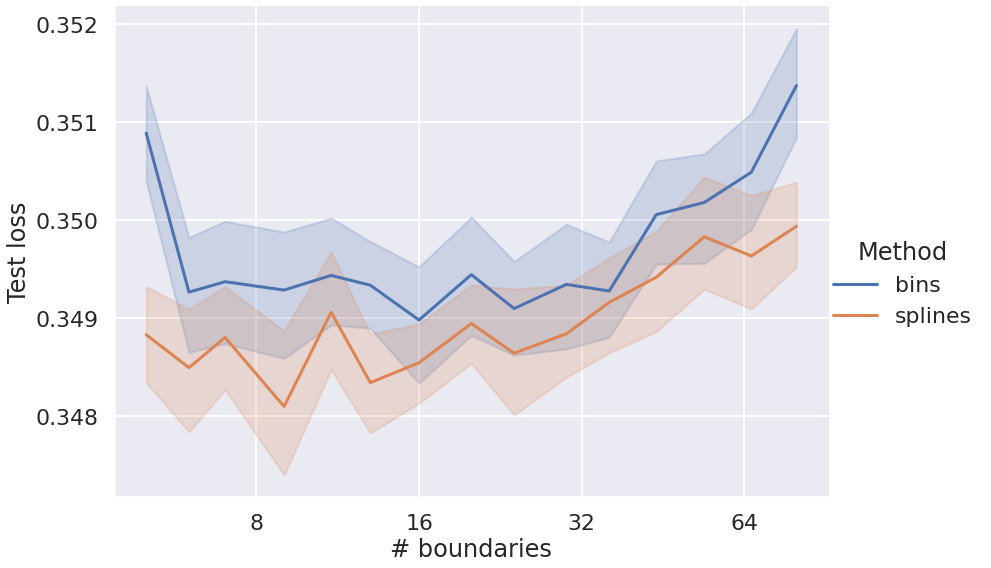

In [35]:
import matplotlib.ticker as tckr

g = sns.relplot(data=to_plot, hue='Method', x='# boundaries', y='Test loss', kind='line', height=8, aspect=1.5)
g.set(xscale="log")
g.ax.xaxis.set_major_locator(tckr.LogLocator(base=2, subs='all'))
g.ax.xaxis.set_major_formatter(tckr.LogFormatter(base=2))

Optimal loss = 0.34352011286537804
25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.34927922519207, test_loss = 0.3487864136695862


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.340548082613945, test_loss = 0.3481057286262512


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34017956260204313, test_loss = 0.34794431924819946


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34003841350078584, test_loss = 0.34787458181381226


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.33995586074829104, test_loss = 0.34783753752708435


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.33989946971416474, test_loss = 0.3478158116340637
Index(['config', 'recency', 'variable', 'value'], dtype='object')


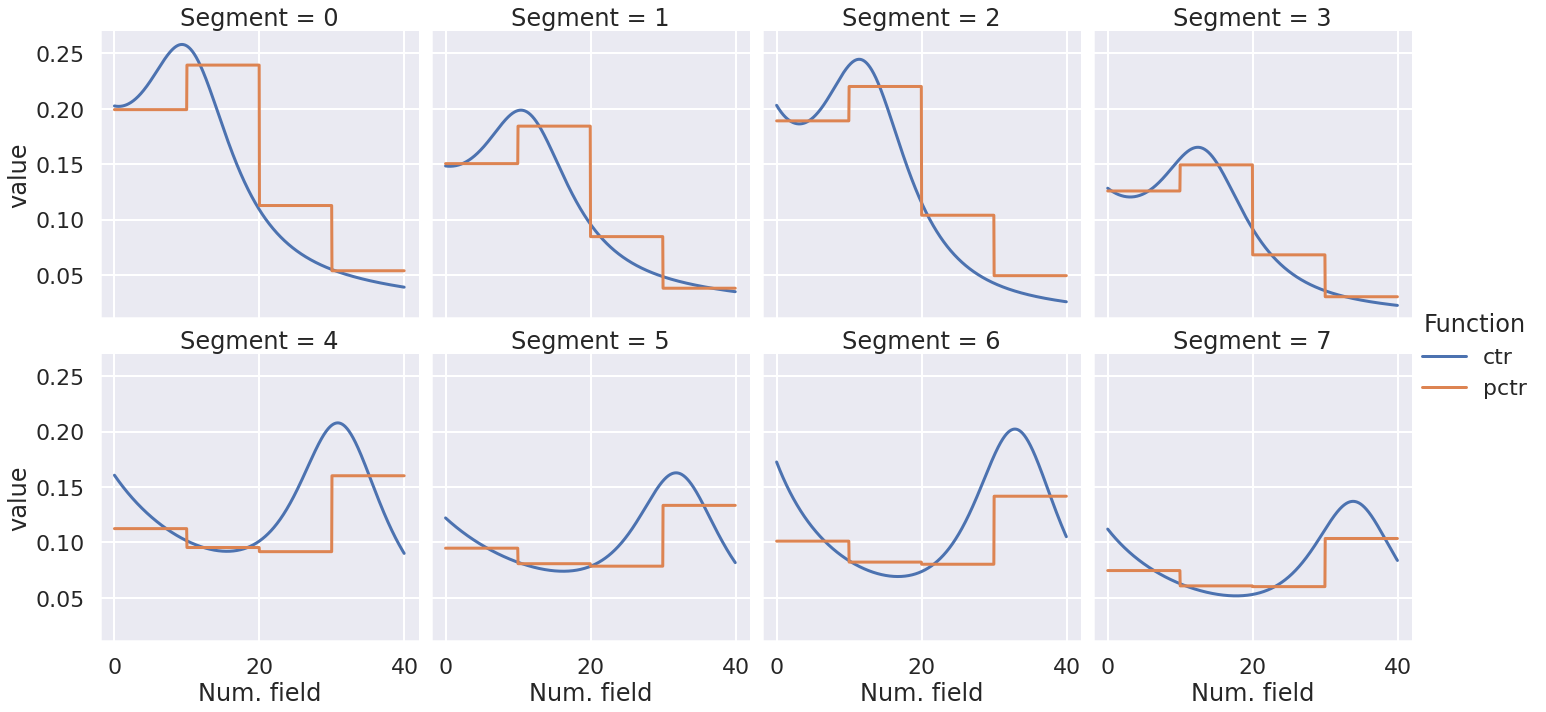

In [128]:
plot_torch_ffm_curves(categoricalTable, recencyPctrFunctions, order=1, num_knots=5)

Optimal loss = 0.34352011286537804
25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.35674660898208616, test_loss = 0.3474774956703186


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.3461565686225891, test_loss = 0.3455573320388794


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3449739882183075, test_loss = 0.3451138436794281


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.344569006986618, test_loss = 0.34496524930000305


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3443623710632324, test_loss = 0.3449031710624695


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34423257335662844, test_loss = 0.34487468004226685
Index(['config', 'recency', 'variable', 'value'], dtype='object')


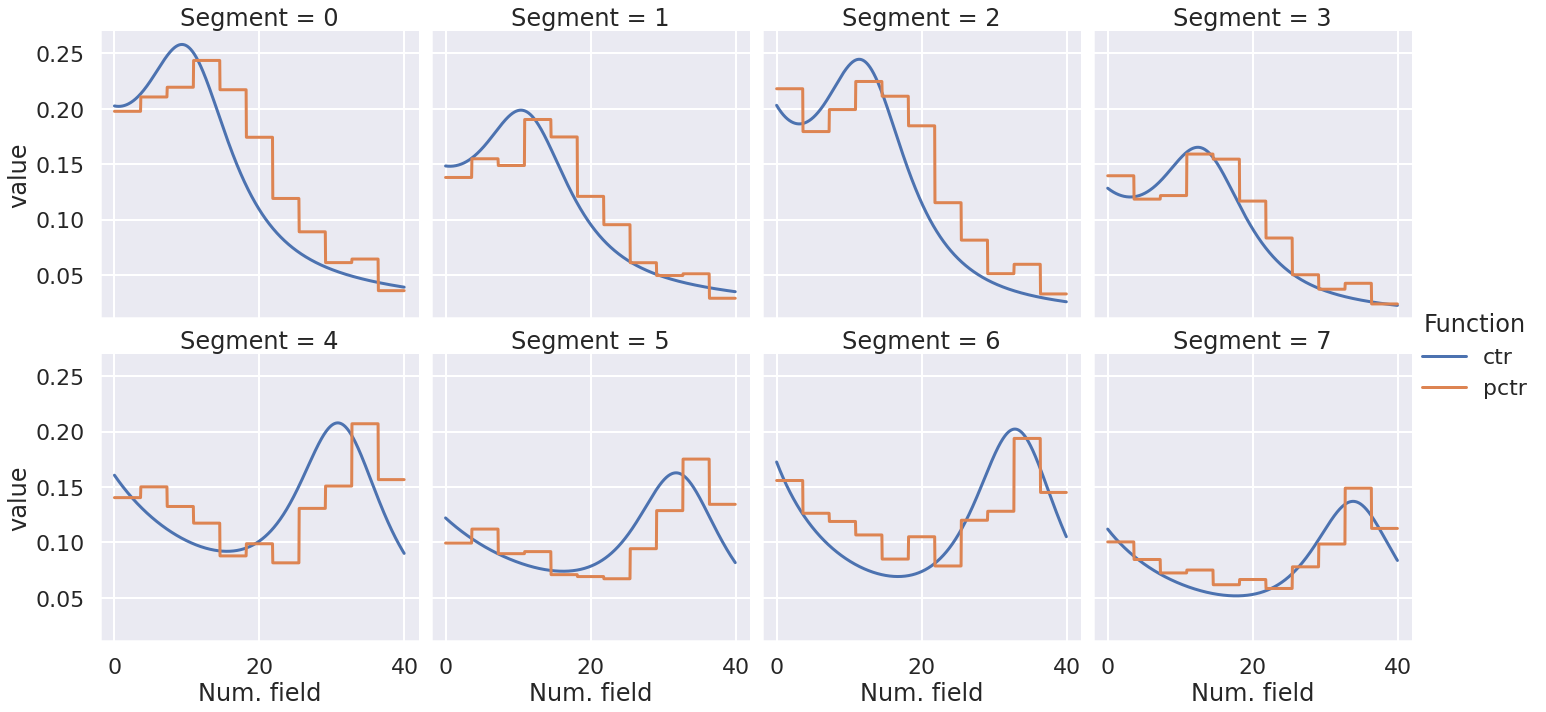

In [130]:
plot_torch_ffm_curves(categoricalTable, recencyPctrFunctions, order=1, num_knots=12)

Optimal loss = 0.34352011286537804
25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3640190015411377, test_loss = 0.3507171869277954


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.34822774300575254, test_loss = 0.3484196066856384


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.34481007137298586, test_loss = 0.34782615303993225


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34314043925285337, test_loss = 0.34769749641418457


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.34207765005111695, test_loss = 0.34771043062210083


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34126804403305055, test_loss = 0.3477899432182312
Index(['config', 'recency', 'variable', 'value'], dtype='object')


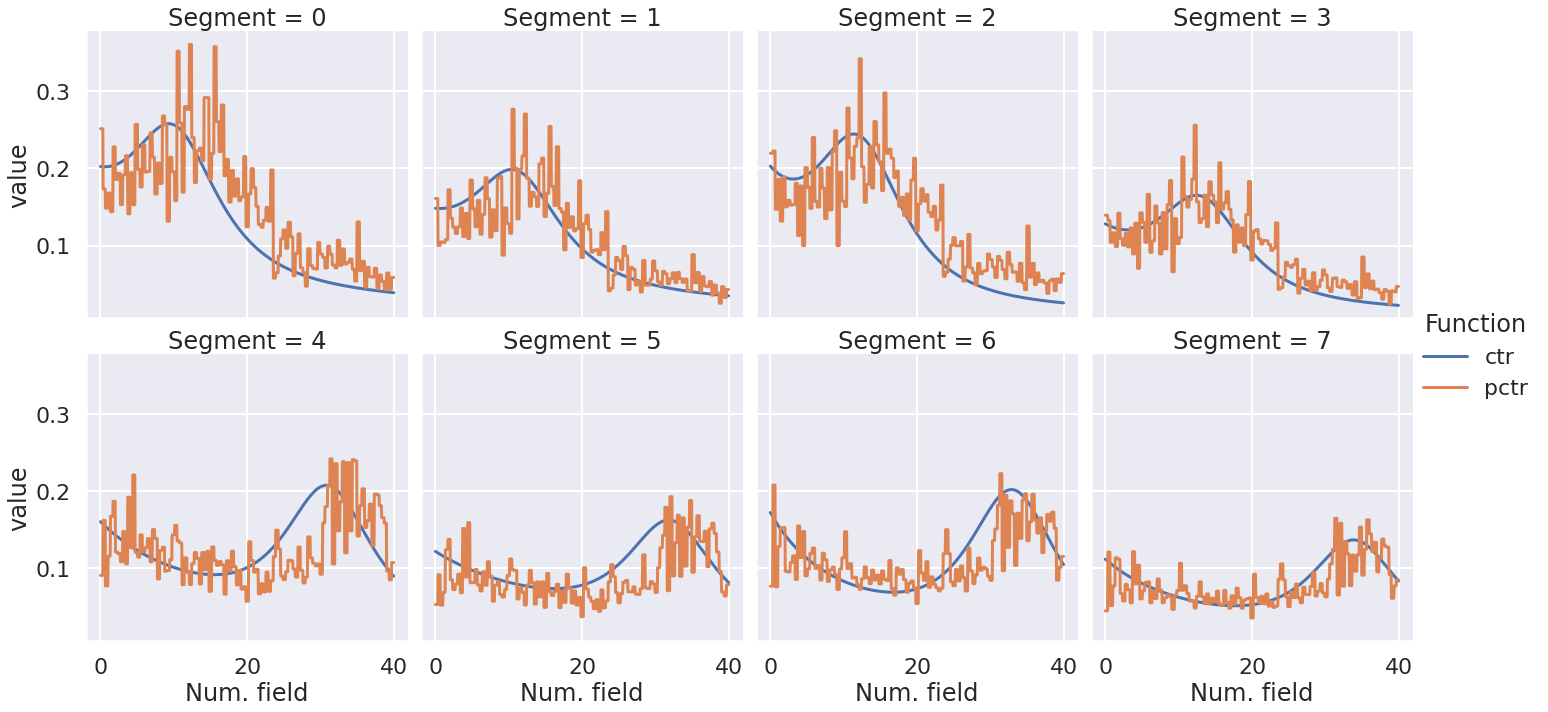

In [131]:
plot_torch_ffm_curves(categoricalTable, recencyPctrFunctions, order=1, num_knots=120)

Optimal loss = 0.34352011286537804
25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3621972397708893, test_loss = 0.34703701734542847


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35037489725112914, test_loss = 0.34420445561408997


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3490664326572418, test_loss = 0.34368404746055603


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.3487767240905762, test_loss = 0.3434743285179138


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3486568525218964, test_loss = 0.34335097670555115


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.34858972754478457, test_loss = 0.34326568245887756
Index(['config', 'recency', 'variable', 'value'], dtype='object')


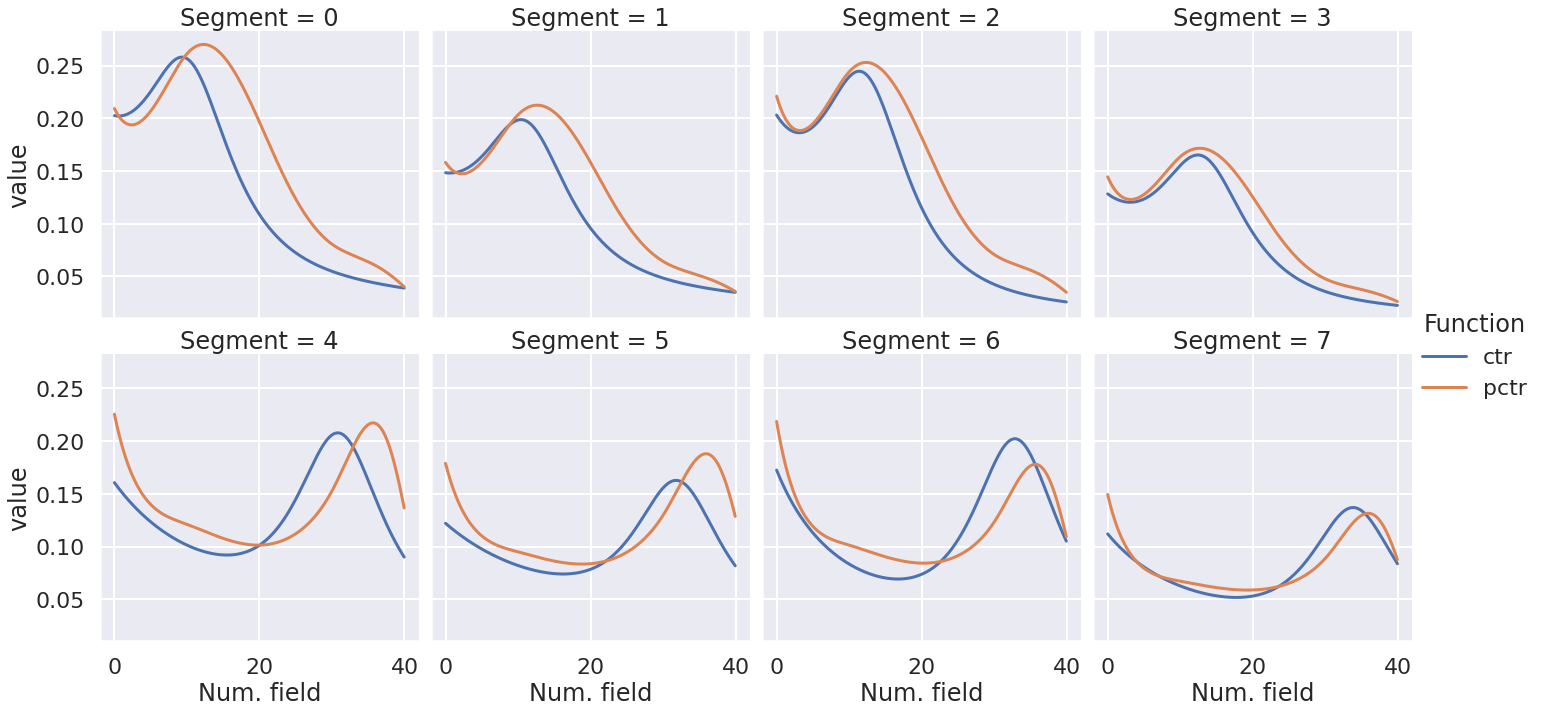

In [132]:
plot_torch_ffm_curves(categoricalTable, recencyPctrFunctions, order=4, num_knots=5)

Optimal loss = 0.34352011286537804
25000 75000


  0%|          | 0/6 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 1, train loss = 0.3606936790561676, test_loss = 0.3438049554824829


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 2, train loss = 0.35027027797698973, test_loss = 0.34308701753616333


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 3, train loss = 0.3497576323032379, test_loss = 0.34289759397506714


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 4, train loss = 0.34958895058631895, test_loss = 0.342800110578537


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 5, train loss = 0.3494990519809723, test_loss = 0.34273916482925415


train:   0%|          | 0/196 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch = 6, train loss = 0.3494401356983185, test_loss = 0.3426973819732666
Index(['config', 'recency', 'variable', 'value'], dtype='object')


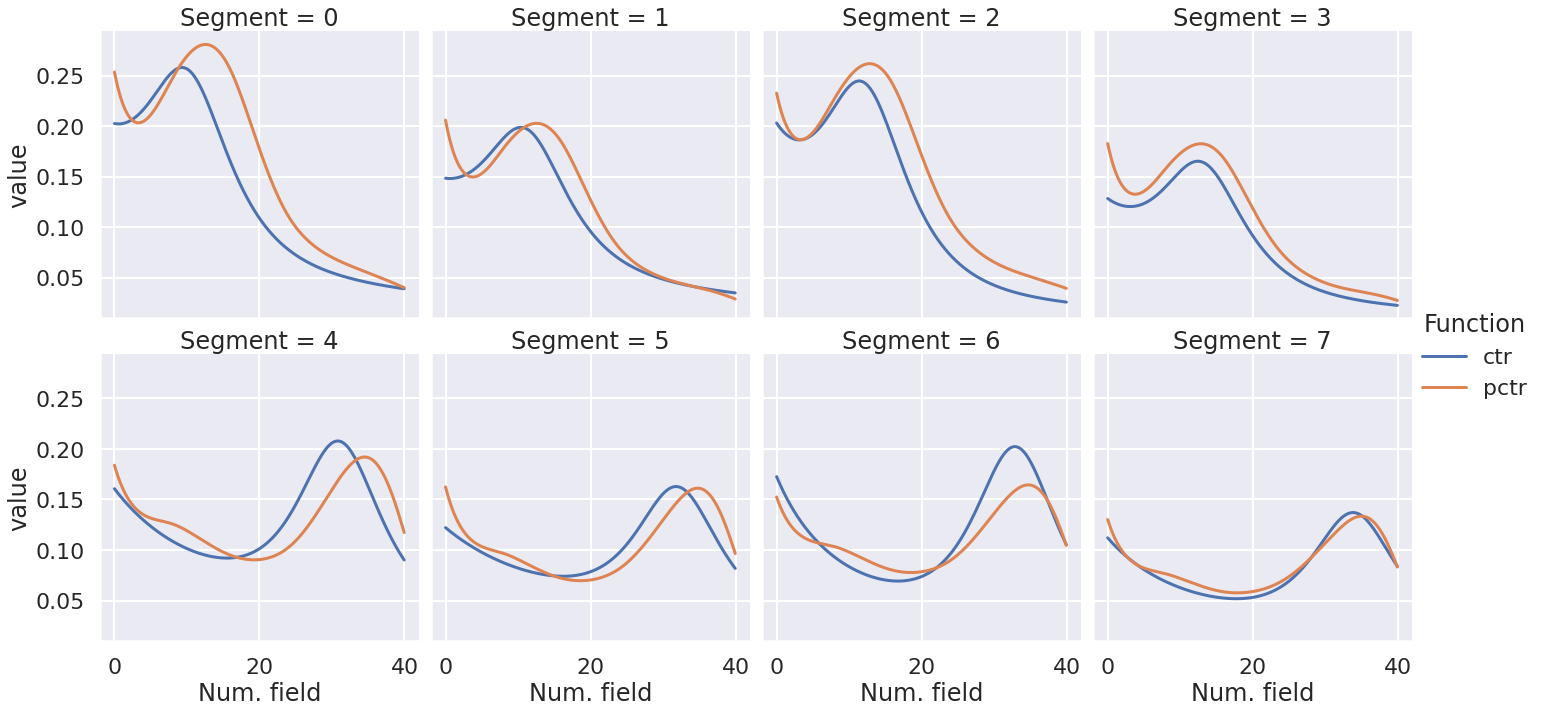

In [133]:
plot_torch_ffm_curves(categoricalTable, recencyPctrFunctions, order=4, num_knots=6)
# recencies = np.random.binomial(40 * 99, np.random.beta(0.9, 1.2, 1000)) / 100
# for ax in g.axes:
#     ax1 = ax.twinx()
#     ax1.bar(recencies, height=ax.get_ylim()[1]/15, width=0.00001, color='black', edgecolor='black', alpha=0.02)
#     ax1.set_ylim(ax.get_ylim())
#     ax1.set_yticks([])